In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import scipy
import json

## Helper Functions

In [2]:
def testing(sample_a, sample_b, alternative):
    shap_a = scipy.stats.shapiro(sample_a)
    print("Sample a: ", shap_a)
    shap_b = scipy.stats.shapiro(sample_b)
    print("Sample b: ", shap_b)
    if shap_a.pvalue > 0.05 and shap_b.pvalue > 0.05:
        statistics = scipy.stats.ttest_ind(sample_a, sample_b, alternative=alternative)
    else:
        statistics = scipy.stats.ranksums(sample_a, sample_b, alternative=alternative)
    return statistics

In [3]:
def plot_distribution(data, name, xlabel="Trust Values", figsize=(6, 4), xticks=None):
    mean, sigma = np.mean(data), np.std(data)
    # create histogram
    fig, ax = plt.subplots(figsize=figsize)
    n, bins, patches = ax.hist(data, bins=30, density=True, alpha=0.5)

    # plot normal distribution curve
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--')

    # set plot parameters
    shap = scipy.stats.shapiro(data)
    print(name, shap)
    pval = shap.pvalue
    if pval < 0.05:
        if pval < 0.0001:
            title = f'{name}, $W={shap.statistic:.2f}$, $p<{0.0001}$*'
        else:
            title = f'{name}, $W={shap.statistic:.2f}$, $p={pval:.4f}$*'
    else:
        title = f'{name}, $W={shap.statistic:.2f}$, $p={pval:.4f}$'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.grid(True)
    if xticks is not None:
        ax.set_xticks(xticks)
    
    return fig


In [4]:
def plot_boxplot(tables, colors, xticks, yticks, ylabel, xlabel=None, title=None, figsize=(6, 4), regex=None,
                 yticks_labels=None):
    fig, ax = plt.subplots(figsize=figsize)
    linewidth = 1.75

    outline_col = "dimgray"
    for (i, table), col in zip(enumerate(tables), colors):
        if regex is not None:
            table = table.filter(regex=regex)
        box = ax.boxplot(table, 
                         positions=[i], widths=0.6, patch_artist=True,
                         boxprops=dict(facecolor=col, color=outline_col, linewidth=linewidth),
                         medianprops=dict(color=outline_col, linewidth=linewidth),
                         whiskerprops=dict(linewidth=linewidth, color=outline_col), 
                         capprops=dict(linewidth=linewidth, color=outline_col),
                         flierprops=dict(marker='o', markerfacecolor=col, markeredgecolor=outline_col, markeredgewidth=0, 
                                         markersize=7))

    # set the labels and title
    ax.set_xticks(ticks=np.arange(len(xticks)),labels=xticks)
    ax.set_yticks(yticks, labels=yticks_labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return fig

In [5]:
def plot_boxplot_testing(tables, colors, xticks, yticks, ylabel, pval,
                         xlabel=None, title=None, figsize=(6, 4), regex=None,
                         yticks_labels=None):
    fig, ax = plt.subplots(figsize=figsize)
    linewidth = 1.75

    outline_col = "dimgray"
    boxes = []
    for (i, table), col in zip(enumerate(tables), colors):
        if regex is not None:
            table = table.filter(regex=regex)
        box = ax.boxplot(table, 
                         positions=[i], widths=0.5, patch_artist=True,
                         boxprops=dict(facecolor=col, color=outline_col, linewidth=linewidth),
                         medianprops=dict(color=outline_col, linewidth=linewidth),
                         whiskerprops=dict(linewidth=linewidth, color=outline_col), 
                         capprops=dict(linewidth=linewidth, color=outline_col),
                         flierprops=dict(marker='o', markerfacecolor=col, markeredgecolor=outline_col, markeredgewidth=0, 
                                         markersize=7))
        # print(box)
        boxes.append(box)
    
    y = 7.5
    x1 = boxes[0]['caps'][0].get_xdata().mean()
    x2 = boxes[1]['caps'][0].get_xdata().mean()
    ax.plot([x1, x2], [y, y], color=outline_col, linewidth=1.25)
    ax.plot([x1, x1], [y, y-0.2], color=outline_col, linewidth=1.25)
    ax.plot([x2, x2], [y, y-0.2], color=outline_col, linewidth=1.25)
    p_value = f'$p={pval:.4f}$' if pval > 0.0001 else f'$p<{0.0001}$'
    ax.text((x1+x2)/2, y+0.1, p_value, ha='center', fontsize=8)
    
    # set the labels and title
    ax.set_xticks(ticks=np.arange(len(xticks)),labels=xticks)
    ax.set_yticks(yticks, labels=yticks_labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return fig

In [6]:
def plot_barplot(data, colors, labels, categories, title, figsize=(6, 4)):
    linewidth = 1.75

    fig, ax = plt.subplots(figsize=figsize)
    handles = []
    left = np.zeros(len(tables))
    for c, category in enumerate(categories):
        data_per_category = data[:, j, :]
        handles.append(ax.barh(labels, data_per_category[:, c], left=left, color=colors[c], label=category, height=0.5))

        left += data_per_category[:, c]

    # set the labels and title
    ax.set_xlabel('Number of Responses')
    ax.set_title(title)
    ax.invert_yaxis()
    ax.legend(handles=handles[::1], loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return fig

## Data

In [7]:
df = pd.read_csv("./data/Results/Main-Study_Results.csv")
# df = df.drop_duplicates(subset=df.columns.tolist()[1:], keep='first')
df = df.drop(columns=['StartDate', 'EndDate', 'Progress', 'Finished', 'RecordedDate', 'UserLanguage'])

likert_scale = [(1, 'Strongly disagree'), (2, 'Disagree'), (3, 'Somewhat disagree'), (4, 'Neither agree nor disagree'), 
                (5, 'Somewhat agree'), (6, 'Agree'), (7, 'Strongly agree')]

for value, text in likert_scale:
    df = df.apply(pd.Series.replace, to_replace=text, value=value)
df['mean1'] = df.filter(regex='Q9.1_').mean(axis=1) # df.filter(regex='Q9.1_(?!1)').mean(axis=1)
df['mean2'] = df.filter(regex='Q19.1_').mean(axis=1) # df.filter(regex='Q19.1_(?!1)').mean(axis=1)

questions1 = [["Q5.2", "Q5.6", "Q5.10", "Q5.14", "Q5.18", "Q5.23", "Q5.27"],
              ["Q6.2", "Q6.6", "Q6.10", "Q6.14", "Q6.18", "Q6.23", "Q6.27"],
              ["Q7.2", "Q7.6", "Q7.10", "Q7.14", "Q7.18", "Q7.23", "Q7.27"],
              ["Q8.2", "Q8.6", "Q8.10", "Q8.14", "Q8.18", "Q8.23", "Q8.27"]]
labels1 = [['grilled_salmon', 'spring_rolls', 'cheese_plate', 'chocolate_mousse', 'macaroni_and_cheese', 
           'chicken_wings', 'fish_and_chips'],
          ['grilled_salmon', 'spring_rolls', 'cheese_plate', 'chocolate_mousse', 'macaroni_and_cheese', 
           'chicken_wings', 'fish_and_chips'],
          ['pork_chop', 'lobster_bisque', 'poutine', 'eggs_benedict', 'croque_madame', 
           'prime_rib', 'pork_chop'],
          ['pork_chop', 'lobster_bisque', 'poutine', 'eggs_benedict', 'croque_madame', 
           'prime_rib', 'pork_chop']]

questions2 = [["Q11.4", "Q11.10", "Q11.16", "Q11.22", "Q11.28", "Q11.35", "Q11.43"],
              ["Q12.4", "Q12.10", "Q12.16", "Q12.22", "Q12.28", "Q12.35", "Q12.43"],
              ["Q13.4", "Q13.10", "Q13.16", "Q13.22", "Q13.28", "Q13.35", "Q13.43"],
              ["Q14.4", "Q14.10", "Q14.16", "Q14.22", "Q14.28", "Q14.35", "Q14.43"],
              ["Q15.4", "Q15.10", "Q15.16", "Q15.22", "Q15.28", "Q15.35", "Q15.43"],
              ["Q16.4", "Q16.10", "Q16.16", "Q16.22", "Q16.28", "Q16.35", "Q16.43"],
              ["Q17.4", "Q17.10", "Q17.16", "Q17.22", "Q17.28", "Q17.35", "Q17.43"],
              ["Q18.4", "Q18.10", "Q18.16", "Q18.22", "Q18.28", "Q18.35", "Q18.43"],
             ]

labels2 = [['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 2
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 3
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 4
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 5
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 6
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 7
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.'],
          # condition 8
          ['I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.', 
           'I think that the criminal defendant is not likely to reoffend.']]

df

,Duration (in seconds),Q1.2,Q3.1_1,Q3.1_2,Q3.1_3,Q4.2,Q4.3,Q5.2,Q5.4,Q5.6,...,Q19.1_4,Q19.1_5,Q19.2,Q19.3,Q19.4,Q20.1,Q20.2,Q20.2_4_TEXT,mean1,mean2
0,419,I agree.,Slightly knowledgeable,Slightly knowledgeable,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,...,6,6,Because its based in correct information,race,priors count,23,Female,NaN,7.0,6.0
1,444,I agree.,Slightly knowledgeable,Slightly knowledgeable,Slightly knowledgeable,The model is a computer program that automatic...,Red parts of the image have a high influence o...,grilled_salmon,"Yes, I agree.",spring_rolls,...,6,6,NaN,race,recidivism decile score,30,Female,NaN,4.8,5.8
2,537,I agree.,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,...,6,6,Model made same decisions as me based on the c...,sex,priors count,30,Female,NaN,5.0,6.0
3,584,I agree.,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,grilled_salmon,"Yes, I agree.",spring_rolls,...,4,3,It’s difficult for the computer to make decisi...,age category,priors count,39,Female,NaN,4.4,3.2
4,696,I agree.,Moderately knowledgeable,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,grilled_salmon,"Yes, I agree.",spring_rolls,...,1,1,seems to place too much weight on the age and ...,age category,recidivism decile score,22,Male,NaN,5.6,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2452,I agree.,Very knowledgeable,Slightly knowledgeable,Slightly knowledgeable,The model is a computer program that automatic...,Red parts of the image have a high influence o...,grilled_salmon,"Yes, I agree.",dumplings,...,5,3,"distrust, since the model does not work with t...",race,sex,38,Male,NaN,5.2,3.8
316,2518,I agree.,Slightly knowledgeable,Slightly knowledgeable,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,...,1,1,Its decisions seemed to be opposite to what th...,juvenile misdemeanor count,recidivism decile score,33,Male,NaN,1.8,1.8
317,2375,I agree.,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,...,2,2,I distrust the decisions because they didn't c...,recidivism decile score,priors count,60,Female,NaN,2.8,2.0
318,1136,I agree.,Moderately knowledgeable,Moderately knowledgeable,Slightly knowledgeable,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,...,5,1,I distrust the decisions because I believe AI...,priors count,sex,34,Male,NaN,4.0,2.8


In [8]:
# df["Q9.2"].values
df["Q19.2"].values

array(['Because its based in correct information', nan,
       'Model made same decisions as me based on the criteria',
       'It’s difficult for the computer to make decisions about things that have so many variables ',
       'seems to place too much weight on the age and race category, and too little on stuff like priors count which i consider to be the real indicator',
       'I think this model is more trustworthy than the previous one because I think it made more right choices.',
       'I found the decisions bizarre - the people with high risk of recidivism / violence and with large numbers of priors were deemed unlikely to reoffend and also it seemed strange that the overall response appeared to combine the inputs in a weird way so even though it looked like reoffending was possible it was not deemed so by the algorithm',
       'The model seems to work exact opposite way. ',
       'because it compares a lot of content that a normal person would not be able to',
       'I did

In [9]:
for l_i, questions in enumerate(questions1):
    for i, q in enumerate(questions):
        df[q] = df[q].apply(lambda x: 1 if pd.notnull(x) and x == labels1[l_i][i]
                                 else 0 if pd.notnull(x) and x != labels1[l_i] [i] else np.nan)

In [10]:
for l_i, questions in enumerate(questions2):
    for i, q in enumerate(questions):
        df[q] = df[q].apply(lambda x: 1 if pd.notnull(x) and x == labels2[l_i][i]
                                 else 0 if pd.notnull(x) and x != labels2[l_i] [i] else np.nan)

In [11]:
mean = df["Duration (in seconds)"].mean()
median = df["Duration (in seconds)"].median()
print("Mean: {:.0f}m {:.0f}s".format(mean // 60, mean % 60))
print("Median: {:.0f}m {:.0f}s".format(median // 60, median % 60))

Mean: 19m 11s
Median: 16m 34s


In [12]:
1280 / (median/(60*60))

4638.147961751384

In [13]:
num_subjects = len(df.index)
print(num_subjects)
age_sum = df["Q20.1"].sum()
print("Age mean:", df["Q20.1"].mean())
print("Age std:", df["Q20.1"].std())

320
Age mean: 31.428125
Age std: 10.601109966579488


In [14]:
gender = df["Q20.2"].value_counts()
print("{:.2f}% (n={}) Male" .format(gender.values[0] / num_subjects * 100, gender.values[0]))
print("{:.2f}% (n={}) Female" .format(gender.values[1] / num_subjects * 100, gender.values[1]))
print("{:.2f}% (n={}) Non-binary / third gender" .format(gender.values[2] / num_subjects * 100, gender.values[2]))
print("{:.2f}% (n={}) Prefer not to say" .format(gender.values[3] / num_subjects * 100, gender.values[3]))

64.69% (n=207) Male
34.06% (n=109) Female
0.94% (n=3) Non-binary / third gender
0.31% (n=1) Prefer not to say


In [15]:
program_knowledge = df["Q3.1_1"].value_counts()
print(program_knowledge)
print("{:.2f}% (n={}) had at least modate knowledge of programming" 
      .format(program_knowledge.values[2:].sum() / num_subjects * 100, program_knowledge.values[2:].sum()))

Slightly knowledgeable      103
Not knowledgeable at all     92
Moderately knowledgeable     70
Very knowledgeable           47
Extremely knowledgeable       8
Name: Q3.1_1, dtype: int64
39.06% (n=125) had at least modate knowledge of programming


In [16]:
algo_knowledge = df["Q3.1_2"].value_counts()
print(algo_knowledge)
print("{:.2f}% (n={}) had at least modate knowledge of computer algorithms" 
      .format(algo_knowledge.values[2:].sum() / num_subjects * 100, algo_knowledge.values[2:].sum()))

Slightly knowledgeable      115
Moderately knowledgeable     92
Not knowledgeable at all     79
Very knowledgeable           28
Extremely knowledgeable       6
Name: Q3.1_2, dtype: int64
35.31% (n=113) had at least modate knowledge of computer algorithms


In [17]:
ml_knowledge = df["Q3.1_3"].value_counts()
print(ml_knowledge)
print("{:.2f}% (n={}) had at least modate knowledge of machine learning" 
      .format(ml_knowledge.values[2:].sum() / num_subjects * 100, ml_knowledge.values[2:].sum()))

Not knowledgeable at all    138
Slightly knowledgeable      110
Moderately knowledgeable     56
Very knowledgeable           13
Extremely knowledgeable       3
Name: Q3.1_3, dtype: int64
22.50% (n=72) had at least modate knowledge of machine learning


# -------------------------------------------------------------------------------------------------------
# User Study 1

In [18]:
user_study1 = df.filter(regex=r'(Q2|Q3|Q4|Q5|Q6|Q7|Q8|Q9|Q20|mean1)')
print(len(user_study1.index))
# user_study1.head()

320


## Filter

In [19]:
q4_2 = "The model is a computer program that automatically classify different types of food."
q4_3 = "Red parts of the image have a high influence on the model's prediction."
user_study1 = user_study1[user_study1["Q4.2"] == q4_2]
user_study1 = user_study1[user_study1["Q4.3"] == q4_3]
print(len(user_study1.index))
user_study1.head()

309


,Q3.1_1,Q3.1_2,Q3.1_3,Q4.2,Q4.3,Q5.2,Q5.4,Q5.6,Q5.8,Q5.10,...,Q9.1_1,Q9.1_2,Q9.1_3,Q9.1_4,Q9.1_5,Q9.2,Q20.1,Q20.2,Q20.2_4_TEXT,mean1
0,Slightly knowledgeable,Slightly knowledgeable,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,NaN,NaN,...,7,7,7,7,7,Because they make sense,23,Female,NaN,7.0
1,Slightly knowledgeable,Slightly knowledgeable,Slightly knowledgeable,The model is a computer program that automatic...,Red parts of the image have a high influence o...,1.0,"Yes, I agree.",1.0,"Yes, I agree.",1.0,...,5,5,5,4,5,NaN,30,Female,NaN,4.8
2,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,NaN,NaN,NaN,NaN,NaN,...,5,5,5,5,5,The model seemed to be accurate more times tha...,30,Female,NaN,5.0
3,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,1.0,"Yes, I agree.",1.0,"Yes, I agree.",1.0,...,5,5,4,4,4,It was looking at the right parts of the foods,39,Female,NaN,4.4
4,Moderately knowledgeable,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,Red parts of the image have a high influence o...,1.0,"Yes, I agree.",1.0,"Yes, I agree.",NaN,...,5,6,5,6,6,seems to get most decisions right,22,Male,NaN,5.6


# -----------------------------------------------------------------------------------------------

## Intuitiveness

Intuitiveness ShapiroResult(statistic=0.9736870527267456, pvalue=0.004247688222676516)


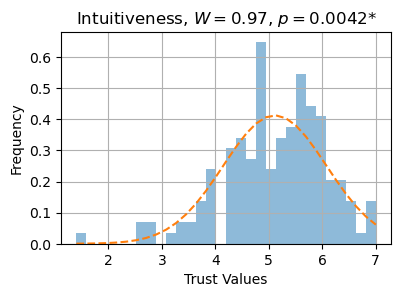

In [20]:
col = user_study1.filter(regex=r'(Q5|Q6)').columns
intuitive1 = user_study1.filter(regex=r'(Q5|Q6|Q9|mean1)')
intuitive1 = intuitive1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
# intuitive1 = intuitive1.dropna(axis = 1, how = 'all', inplace = False)
# intuitive1
fig = plot_distribution(intuitive1["mean1"].values, "Intuitiveness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_intuitiveness.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness

Non-intuitiveness ShapiroResult(statistic=0.9848827123641968, pvalue=0.09561825543642044)


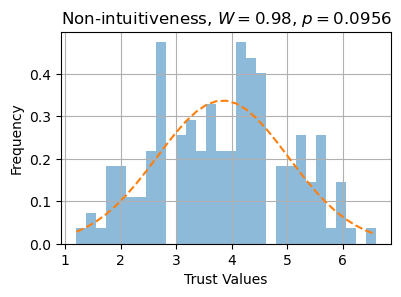

In [21]:
col = user_study1.filter(regex=r'(Q7|Q8)').columns
nonintuitive1 = user_study1.filter(regex=r'(Q7|Q8|Q9|mean1)')
nonintuitive1 = nonintuitive1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive1 = nonintuitive1.dropna(axis = 1, how = 'all', inplace = False)
# nonintuitive
fig = plot_distribution(nonintuitive1["mean1"].values, "Non-intuitiveness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_nonintuitiveness.pdf", bbox_inches='tight')
# plt.close()

## Faithfulness

Faithfulness ShapiroResult(statistic=0.9631819725036621, pvalue=0.00039815393392927945)


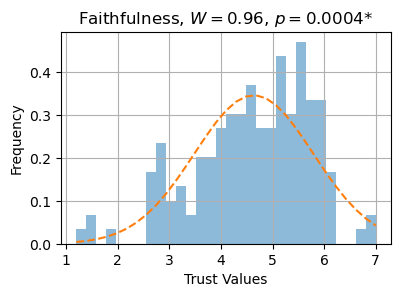

In [22]:
col = user_study1.filter(regex=r'(Q5|Q7)').columns
faithful1 = user_study1.filter(regex=r'(Q5|Q7|Q9|mean1)')
faithful1 = faithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
faithful1 = faithful1.dropna(axis = 1, how = 'all', inplace = False)
# faithful
fig = plot_distribution(faithful1["mean1"].values, "Faithfulness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_faithfulness.pdf", bbox_inches='tight')
# plt.close()

## Unfaithfulness

Unfaithfulness ShapiroResult(statistic=0.9780725240707397, pvalue=0.01422890741378069)


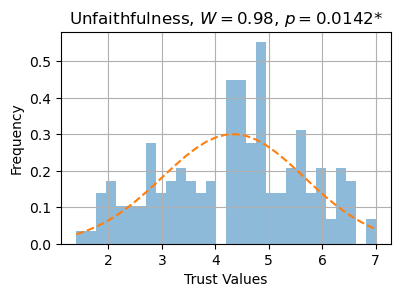

In [23]:
col = user_study1.filter(regex=r'(Q6|Q8)').columns
unfaithful1 = user_study1.filter(regex=r'(Q6|Q8|Q9|mean1)')
unfaithful1 = unfaithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
unfaithful1 = unfaithful1.dropna(axis = 1, how = 'all', inplace = False)
fig = plot_distribution(unfaithful1["mean1"].values, "Unfaithfulness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_unfaithfulness.pdf", bbox_inches='tight')
# plt.close()

## Condition 1 - Intuitiveness/Faithfulness

Condition 1 ShapiroResult(statistic=0.9515533447265625, pvalue=0.004549253266304731)
79


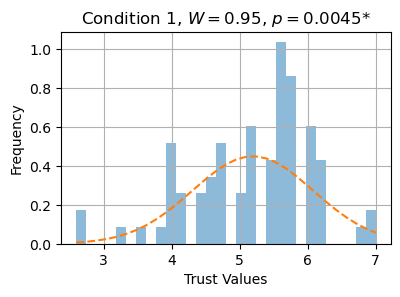

In [24]:
col = user_study1.filter(regex='Q5').columns
intuitive_faithful1 = user_study1.filter(regex=r'(Q5|Q9|mean1)')
intuitive_faithful1 = intuitive_faithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_faithful1 = intuitive_faithful1.dropna(axis = 1, how = 'all', inplace = False)
# intuitive_faithful
fig = plot_distribution(intuitive_faithful1["mean1"].values, "Condition 1", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_condition1.pdf", bbox_inches='tight')
# plt.close()
print(len(intuitive_faithful1.index))

predictions = "$|".join(questions1[0])
predictions_mean1 = intuitive_faithful1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean1 = predictions_mean1[~np.isnan(predictions_mean1)]
# predictions_mean1

## Condition 2 - Intuitiveness/Unfaithfulness

Condition 2 ShapiroResult(statistic=0.9673574566841125, pvalue=0.04274291172623634)
78


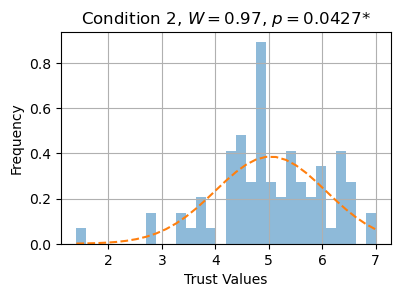

In [25]:
col = user_study1.filter(regex='Q6').columns
intuitive_unfaithful1 = user_study1.filter(regex=r'(Q6|Q9|mean1)')
intuitive_unfaithful1 = intuitive_unfaithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_unfaithful1 = intuitive_unfaithful1.dropna(axis = 1, how = 'all', inplace = False)
# intuitive_unfaithful
fig = plot_distribution(intuitive_unfaithful1["mean1"].values, "Condition 2", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_condition2.pdf", bbox_inches='tight')
# plt.close()
print(len(intuitive_unfaithful1.index))

predictions = "$|".join(questions1[1])
predictions_mean2 = intuitive_unfaithful1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean2 = predictions_mean2[~np.isnan(predictions_mean2)]
# predictions_mean2

## Condition 3 - Non-intuitiveness/Faithfulness

Condition 3 ShapiroResult(statistic=0.9672694802284241, pvalue=0.04929061606526375)
75


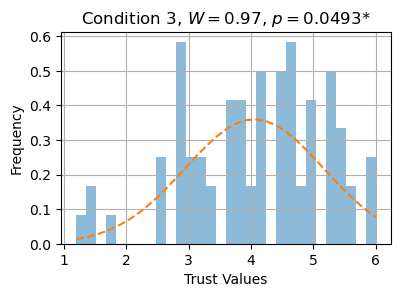

In [26]:
col = user_study1.filter(regex='Q7').columns
nonintuitive_faithful1 = user_study1.filter(regex=r'(Q7|Q9|mean1)')
nonintuitive_faithful1 = nonintuitive_faithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_faithful1 = nonintuitive_faithful1.dropna(axis = 1, how = 'all', inplace = False)
# nonintuitive_faithful
fig = plot_distribution(nonintuitive_faithful1["mean1"].values, "Condition 3", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_condition3.pdf", bbox_inches='tight')
# plt.close()
print(len(nonintuitive_faithful1.index))

predictions = "$|".join(questions1[2])
predictions_mean3 = nonintuitive_faithful1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean3 = predictions_mean3[~np.isnan(predictions_mean3)]
# predictions_mean3

## Condition 4 - Non-intuitiveness/Unfaithfulness

Condition 4 ShapiroResult(statistic=0.9667056798934937, pvalue=0.04105332866311073)
77


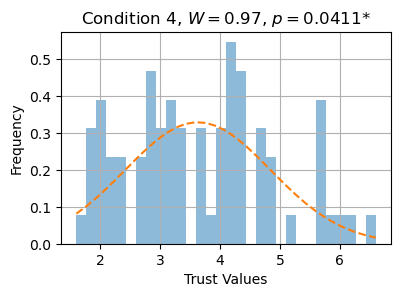

In [27]:
col = user_study1.filter(regex='Q8').columns
nonintuitive_unfaithful1 = user_study1.filter(regex=r'(Q8|Q9|mean1)')
nonintuitive_unfaithful1 = nonintuitive_unfaithful1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_unfaithful1 = nonintuitive_unfaithful1.dropna(axis = 1, how = 'all', inplace = False)
# nonintuitive_unfaithful
fig = plot_distribution(nonintuitive_unfaithful1["mean1"].values, "Condition 4", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study1/distribution_condition4.pdf", bbox_inches='tight')
# plt.close()
print(len(nonintuitive_unfaithful1.index))

predictions = "$|".join(questions1[3])
predictions_mean4 = nonintuitive_unfaithful1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean4 = predictions_mean4[~np.isnan(predictions_mean4)]
# predictions_mean4

## Prediction Alignment - Intuitiveness/Non-intuitiveness

In [28]:
intuitive = np.concatenate((predictions_mean1, predictions_mean2))
nonintuitive = np.concatenate((predictions_mean3, predictions_mean4))
print(np.median(intuitive), np.median(nonintuitive))
print(testing(intuitive, nonintuitive, 'two-sided'))
print(np.arange(0, 1.2, 0.2))

0.8 0.225
Sample a:  ShapiroResult(statistic=0.8280501365661621, pvalue=2.647338294761714e-12)
Sample b:  ShapiroResult(statistic=0.9312082529067993, pvalue=1.0453528602738515e-06)
RanksumsResult(statistic=14.530673220591572, pvalue=7.745544748370025e-48)
[0.  0.2 0.4 0.6 0.8 1. ]


Intuitiveness ShapiroResult(statistic=0.8280501365661621, pvalue=2.647338294761714e-12)
Non-intuitiveness ShapiroResult(statistic=0.9312082529067993, pvalue=1.0453528602738515e-06)


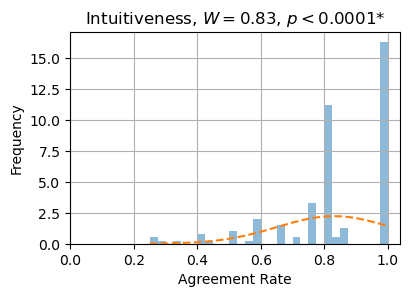

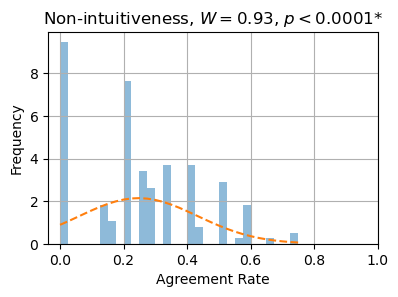

In [29]:
datas = [intuitive, nonintuitive]
names = ["Intuitiveness", "Non-intuitiveness"]
for i, data in enumerate(datas):
    fig = plot_distribution(data, names[i], xlabel="Agreement Rate", figsize=(4.25,2.75), xticks=np.arange(0, 1.2, 0.2))
#     fig.savefig(f"./result_imgs/study1/prediction_alignment_{names[i]}.pdf", bbox_inches='tight')
#     plt.close()

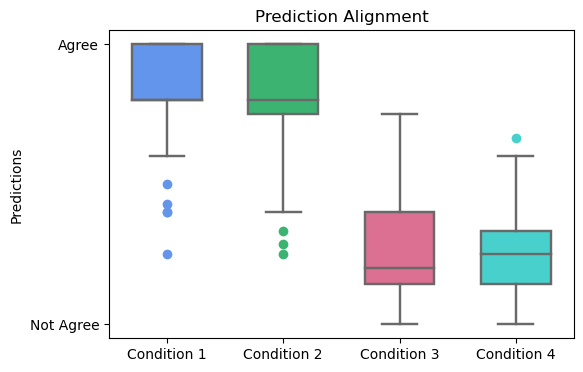

In [30]:
colors = ['cornflowerblue', 'mediumseagreen', 'palevioletred', 'mediumturquoise']
tables = [predictions_mean1, predictions_mean2, predictions_mean3, predictions_mean4]
x_ticks = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4']
y_ticks = ['Not Agree', 'Agree']
ylabel = "Predictions"
title= "Prediction Alignment"
fig = plot_boxplot(tables=tables, colors=colors, xticks=x_ticks, 
                   yticks=np.arange(len(y_ticks)), ylabel=ylabel, title=title, yticks_labels=y_ticks)
# fig.savefig(f"./result_imgs/study1/prediction_alignment.pdf", bbox_inches='tight')
# # plt.close()

In [31]:
testing(intuitive, nonintuitive, 'two-sided')

Sample a:  ShapiroResult(statistic=0.8280501365661621, pvalue=2.647338294761714e-12)
Sample b:  ShapiroResult(statistic=0.9312082529067993, pvalue=1.0453528602738515e-06)


RanksumsResult(statistic=14.530673220591572, pvalue=7.745544748370025e-48)

In [32]:
print(np.median(intuitive))
print(np.median(nonintuitive))

0.8
0.225


## Subjective User Trust

In [33]:
tables = [intuitive_faithful1, intuitive_unfaithful1, nonintuitive_faithful1, nonintuitive_unfaithful1]
x_ticks = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4']
y_ticks = np.arange(1,7+1)
ylabel = "7-point Likert-scale Score"
title= "Subjective User Trust"
# fig = plot_boxplot(tables, colors, x_ticks, y_ticks, ylabel, title=title, regex=r'(mean1)')
# fig.savefig(f"./result_imgs/study1/us1_user_trust.pdf", bbox_inches='tight')

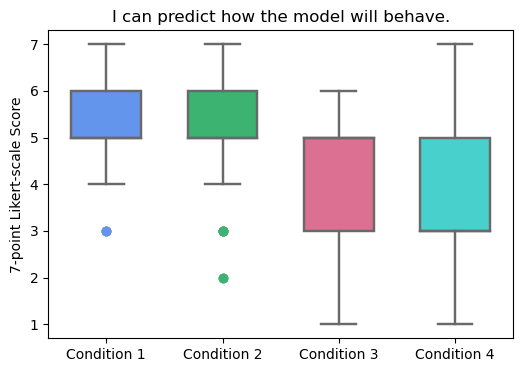

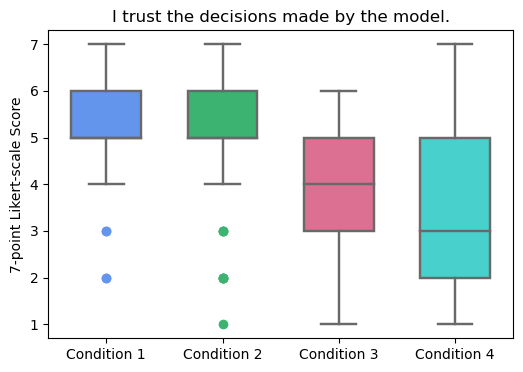

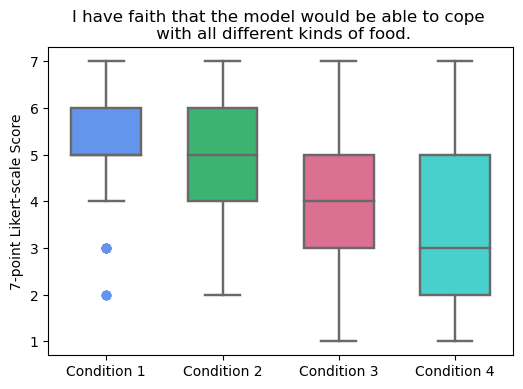

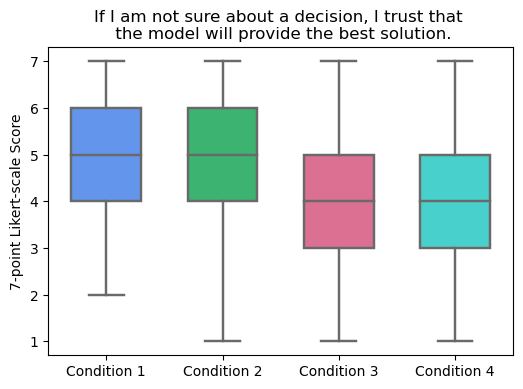

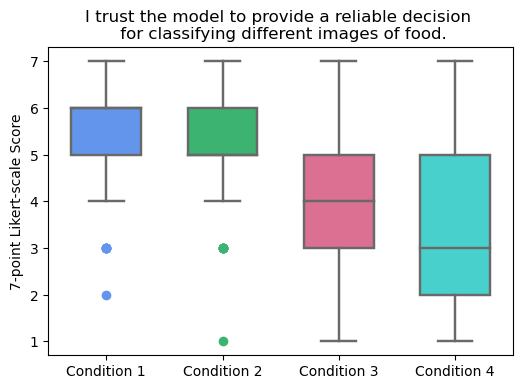

In [34]:
questions_us1 = ['I can predict how the model will behave.',
                 'I trust the decisions made by the model.',
                 'I have faith that the model would be able to cope \n with all different kinds of food.',
                 'If I am not sure about a decision, I trust that \n the model will provide the best solution.',
                 'I trust the model to provide a reliable decision \n for classifying different images of food.']

for j in range(0, 5):
    title = questions_us1[j]
    fig = plot_boxplot(tables, colors, x_ticks, y_ticks, ylabel, title=title, regex=r'(Q9.1_%s)' % (j+1))
#     fig.savefig(f"./result_imgs/study1/us1_user_trust_question{j+1}.pdf", bbox_inches='tight')
#     plt.close()

## Likert-scale User Judgment

In [35]:
likert_scale_score = np.zeros((5, 7))
trust = user_study1.filter(regex='Q9.1_')
for j, col in enumerate(trust.columns):
    score = list(trust[col].values)
    for i in range(1, 7+1):
        likert_scale_score[j, i-1] = score.count(i)
        
likert_scale_score

array([[  4.,  26.,  54.,  32., 121.,  62.,  10.],
       [  7.,  34.,  44.,  30.,  98.,  75.,  21.],
       [ 11.,  39.,  55.,  33.,  83.,  69.,  19.],
       [  9.,  31.,  50.,  59.,  78.,  65.,  17.],
       [  8.,  21.,  54.,  37.,  91.,  82.,  16.]])

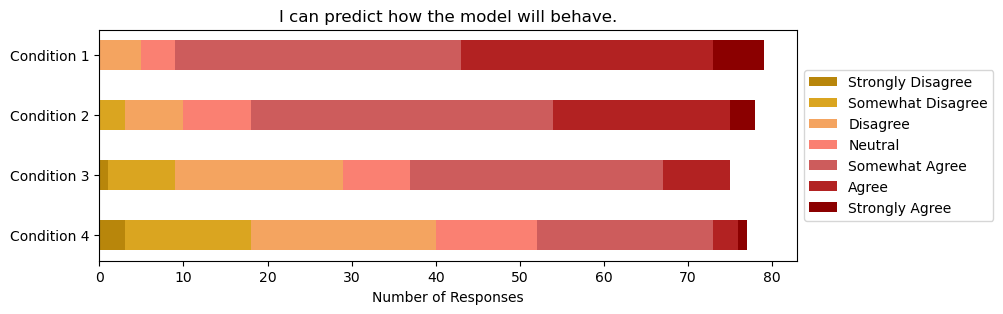

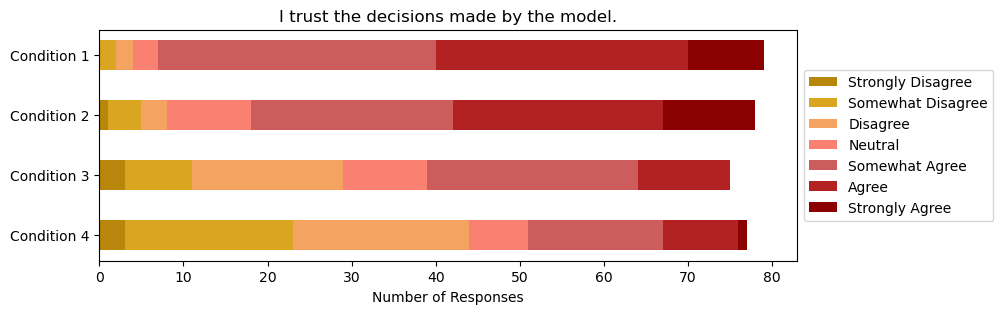

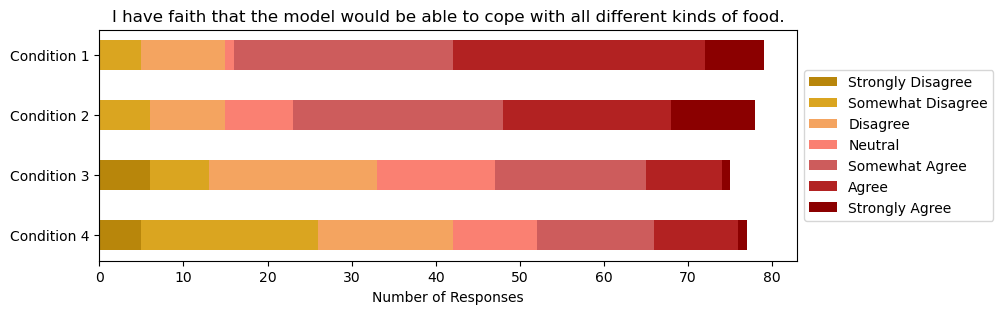

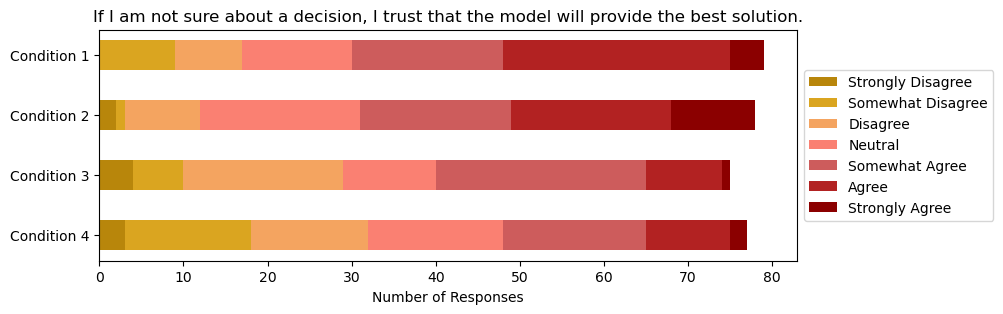

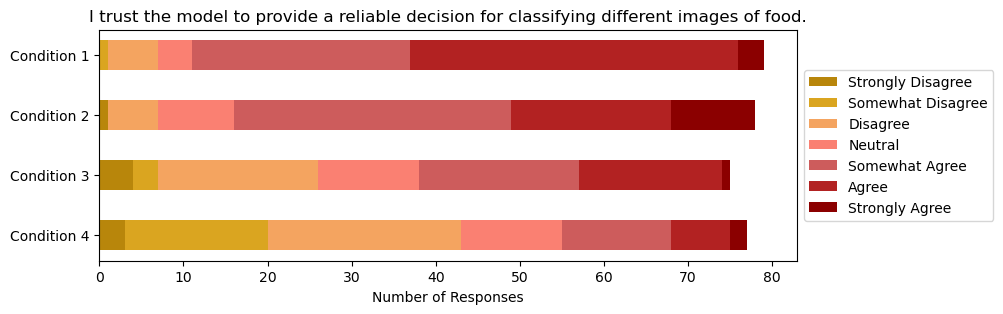

In [36]:
questions_us1 = ['I can predict how the model will behave.',
                 'I trust the decisions made by the model.',
                 'I have faith that the model would be able to cope with all different kinds of food.',
                 'If I am not sure about a decision, I trust that the model will provide the best solution.',
                 'I trust the model to provide a reliable decision for classifying different images of food.']

colors = ['darkgoldenrod', 'goldenrod', 'sandybrown', "salmon", "indianred", "firebrick", "darkred"]
data = np.zeros((4, 5, 7))

# Define the categories for the Likert scale
categories = ['Strongly Disagree', 'Somewhat Disagree', 'Disagree', 'Neutral', 'Somewhat Agree', 'Agree', 'Strongly Agree']
tables = [intuitive_faithful1, intuitive_unfaithful1, nonintuitive_faithful1, nonintuitive_unfaithful1]
for i, table in enumerate(tables):
    trust = table.filter(regex='Q9.1_')
    for t, col in enumerate(trust.columns):
        score = list(trust[col].values)
        for l in range(1, 7+1):
            data[i, t, l-1] = score.count(l)
            
labels = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4']
for j in range(0, 5):
    fig = plot_barplot(data, colors, labels, categories, questions_us1[j], figsize=(9,3))
#     fig.savefig(f"./result_imgs/study1/questions_trust_counts{j+1}.pdf", bbox_inches='tight')
#     plt.close()

# -------------------------------------------------------------------------------------------------------

## Testing Hypothesis H1
### Intuitive <-> Non-intuitive

Sample a:  ShapiroResult(statistic=0.9736870527267456, pvalue=0.004247688222676516)
Sample b:  ShapiroResult(statistic=0.9848827123641968, pvalue=0.09561825543642044)
RanksumsResult(statistic=8.962428561074844, pvalue=1.5880237442139253e-19)


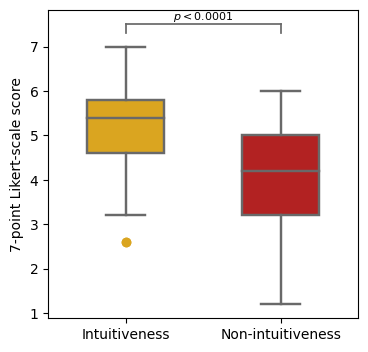

In [37]:
res = testing(intuitive1['mean1'].values, nonintuitive1['mean1'].values, 'greater')
print(res)

fig = plot_boxplot_testing(tables=[intuitive_faithful1['mean1'].values, nonintuitive_faithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitiveness', 'Non-intuitiveness'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H1_result3.pdf", bbox_inches='tight')

In [38]:
print(intuitive1['mean1'].median())
print(nonintuitive1['mean1'].median())

5.2
4.0


### Intuitive/Faithful (Condition 1) <-> Non-intuitive/Faithful (Condition 3)

Sample a:  ShapiroResult(statistic=0.9515533447265625, pvalue=0.004549253266304731)
Sample b:  ShapiroResult(statistic=0.9672694802284241, pvalue=0.04929061606526375)
RanksumsResult(statistic=6.221018128713232, pvalue=2.469695411534832e-10)


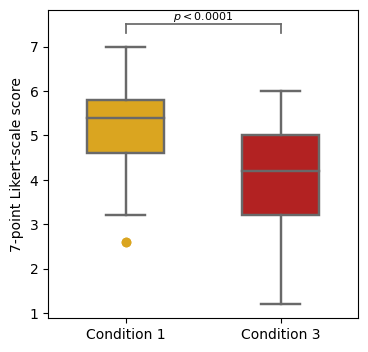

In [39]:
res = testing(intuitive_faithful1['mean1'].values, nonintuitive_faithful1['mean1'].values, 'greater')
print(res)

fig = plot_boxplot_testing(tables=[intuitive_faithful1['mean1'].values, nonintuitive_faithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 1', 'Condition 3'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H1_result1.pdf", bbox_inches='tight')

In [40]:
print(intuitive_faithful1['mean1'].median())
print(nonintuitive_faithful1['mean1'].median())

5.4
4.2


### Intuitive/Unfaithful (Condition 2) <-> Non-intuitive/Unfaithful (Condition 4)

Sample a:  ShapiroResult(statistic=0.9673574566841125, pvalue=0.04274291172623634)
Sample b:  ShapiroResult(statistic=0.9667056798934937, pvalue=0.04105332866311073)
RanksumsResult(statistic=6.69948631486899, pvalue=1.0457672669934643e-11)


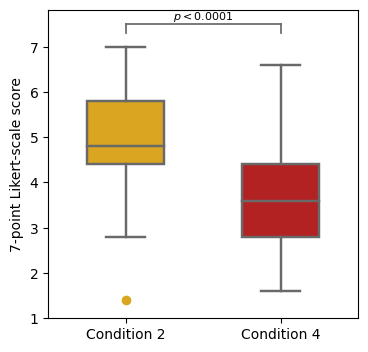

In [41]:
res = testing(intuitive_unfaithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values, 'greater')
print(res)

fig = plot_boxplot_testing(tables=[intuitive_unfaithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 2', 'Condition 4'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H1_result2.pdf", bbox_inches='tight')

In [42]:
print(intuitive_unfaithful1['mean1'].median())
print(nonintuitive_unfaithful1['mean1'].median())

4.8
3.6


## Testing Hypothesis H2
### Faithful <-> Unfaithful

Sample a:  ShapiroResult(statistic=0.9631819725036621, pvalue=0.00039815393392927945)
Sample b:  ShapiroResult(statistic=0.9780725240707397, pvalue=0.01422890741378069)
RanksumsResult(statistic=2.129853309329446, pvalue=0.03318372590335261)


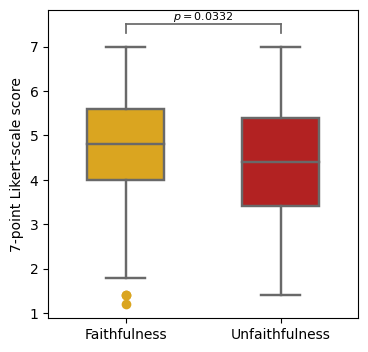

In [43]:
res = testing(faithful1['mean1'].values, unfaithful1['mean1'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[faithful1['mean1'].values, unfaithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Faithfulness', 'Unfaithfulness'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H2_result1.pdf", bbox_inches='tight')

In [44]:
print(faithful1['mean1'].median())
print(unfaithful1['mean1'].median())

4.8
4.4


### Intuitive/Faithful (Condition 1) <-> Intuitive/Unfaithful (Condition 2)

Sample a:  ShapiroResult(statistic=0.9515533447265625, pvalue=0.004549253266304731)
Sample b:  ShapiroResult(statistic=0.9673574566841125, pvalue=0.04274291172623634)
RanksumsResult(statistic=1.1480187605420882, pvalue=0.25096081918696356)


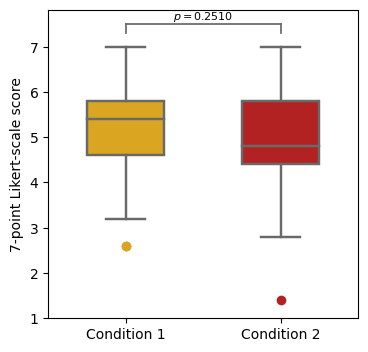

In [45]:
res = testing(intuitive_faithful1['mean1'].values, intuitive_unfaithful1['mean1'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_faithful1['mean1'].values, intuitive_unfaithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 1', 'Condition 2'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H2_result2.pdf", bbox_inches='tight')

In [46]:
print(intuitive_faithful1['mean1'].median())
print(intuitive_unfaithful1['mean1'].median())

5.4
4.8


### Non-intuitive/Faithful (Condition 3) <-> Non-intuitive/Unfaithful (Condition 4)

Sample a:  ShapiroResult(statistic=0.9672694802284241, pvalue=0.04929061606526375)
Sample b:  ShapiroResult(statistic=0.9667056798934937, pvalue=0.04105332866311073)
RanksumsResult(statistic=2.4267480684920133, pvalue=0.015234831006900743)


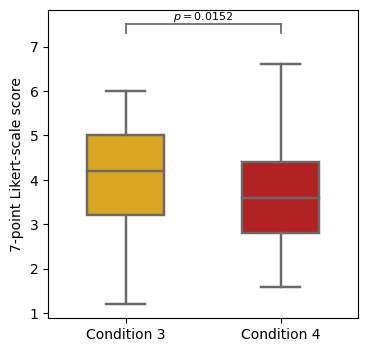

In [47]:
res = testing(nonintuitive_faithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[nonintuitive_faithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 3', 'Condition 4'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/H2_result3.pdf", bbox_inches='tight')

In [48]:
print(nonintuitive_faithful1['mean1'].median())
print(nonintuitive_unfaithful1['mean1'].median())

4.2
3.6


## Testing Addition Tests for Appendix

Sample a:  ShapiroResult(statistic=0.9515533447265625, pvalue=0.004549253266304731)
Sample b:  ShapiroResult(statistic=0.9667056798934937, pvalue=0.04105332866311073)
RanksumsResult(statistic=7.321618366791703, pvalue=2.449980808812787e-13)
5.4
3.6


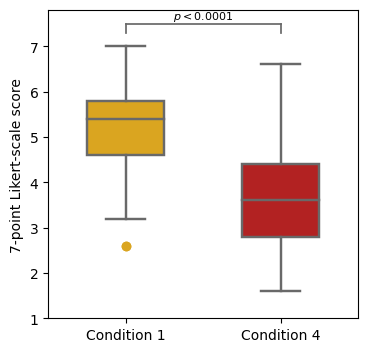

In [49]:
# Condition 1 vs Condition 4
res = testing(intuitive_faithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_faithful1['mean1'].values, nonintuitive_unfaithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 1', 'Condition 4'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/additional_res_1vs4.pdf", bbox_inches='tight')
print(intuitive_faithful1['mean1'].median())
print(nonintuitive_unfaithful1['mean1'].median())

Sample a:  ShapiroResult(statistic=0.9673574566841125, pvalue=0.04274291172623634)
Sample b:  ShapiroResult(statistic=0.9672694802284241, pvalue=0.04929061606526375)
RanksumsResult(statistic=5.031055404337988, pvalue=4.87787148525679e-07)
4.8
4.2


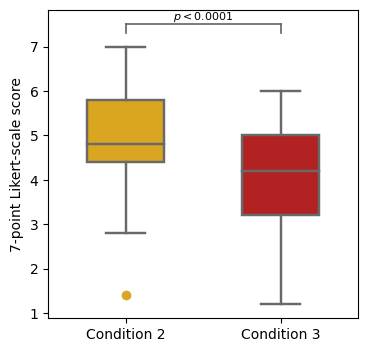

In [50]:
# Condition 2 vs Condition 3
res = testing(intuitive_unfaithful1['mean1'].values, nonintuitive_faithful1['mean1'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_unfaithful1['mean1'].values, nonintuitive_faithful1['mean1'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Condition 2', 'Condition 3'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study1/additional_res_2vs3.pdf", bbox_inches='tight')
print(intuitive_unfaithful1['mean1'].median())
print(nonintuitive_faithful1['mean1'].median())

# -----------------------------------------------------------------------------------------------------------
# User Study 2

In [51]:
user_study2 = df.filter(regex=r'(Q2|Q3|Q10|Q11|Q12|Q13|Q14|Q15|Q16|Q17|Q18|Q19|Q20|mean2)')
print(len(user_study2.index))

320


In [52]:
q10_2 = "The model is a computer program that automatically evaluates if a criminal defendant is likely to reoffend."
q10_3 = "The attributes will influence the automated decisions for criminal recidivism."
q10_4 = "Positive values (in red) have a higher impact to the model's decision that the defendant is likely to reoffend."
# user_study2 = user_study2[user_study2["Q10.2"] == q10_2]
# print(len(user_study2.index))
user_study2 = user_study2[user_study2["Q10.3"] == q10_3]
print(len(user_study2.index))
user_study2 = user_study2[user_study2["Q10.4"] == q10_4]
print(len(user_study2.index))
user_study2.head()

309
253


,Q3.1_1,Q3.1_2,Q3.1_3,Q10.2,Q10.3,Q10.4,Q11.2,Q11.4,Q11.6,Q11.8,...,Q19.1_3,Q19.1_4,Q19.1_5,Q19.2,Q19.3,Q19.4,Q20.1,Q20.2,Q20.2_4_TEXT,mean2
0,Slightly knowledgeable,Slightly knowledgeable,Not knowledgeable at all,The model is a computer program that automatic...,The attributes will influence the automated de...,Positive values (in red) have a higher impact ...,NaN,NaN,NaN,NaN,...,6,6,6,Because its based in correct information,race,priors count,23,Female,NaN,6.0
1,Slightly knowledgeable,Slightly knowledgeable,Slightly knowledgeable,The model is a computer program that automatic...,The attributes will influence the automated de...,Positive values (in red) have a higher impact ...,NaN,NaN,NaN,NaN,...,6,6,6,NaN,race,recidivism decile score,30,Female,NaN,5.8
2,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,The attributes will influence the automated de...,Positive values (in red) have a higher impact ...,No,0.0,"Yes, I agree.",NaN,...,6,6,6,Model made same decisions as me based on the c...,sex,priors count,30,Female,NaN,6.0
3,Not knowledgeable at all,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,The attributes will influence the automated de...,Positive values (in red) have a higher impact ...,NaN,NaN,NaN,NaN,...,3,4,3,It’s difficult for the computer to make decisi...,age category,priors count,39,Female,NaN,3.2
4,Moderately knowledgeable,Not knowledgeable at all,Not knowledgeable at all,The model is a computer program that automatic...,The attributes will influence the automated de...,Positive values (in red) have a higher impact ...,NaN,NaN,NaN,NaN,...,1,1,1,seems to place too much weight on the age and ...,age category,recidivism decile score,22,Male,NaN,2.0


## Features

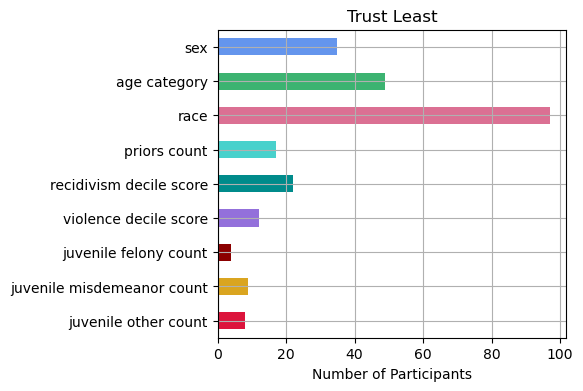

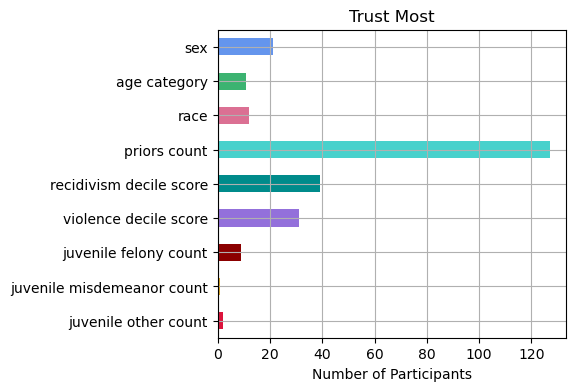

In [53]:
features = ['sex', 'age category', 'race', 'priors count', 
            'recidivism decile score', 'violence decile score', 
            'juvenile felony count', 'juvenile misdemeanor count', 'juvenile other count']
feature_counts = [user_study2["Q19.3"].value_counts(), user_study2["Q19.4"].value_counts()]
colors = ['cornflowerblue', 'mediumseagreen', 'palevioletred', 'mediumturquoise',
          'darkcyan', 'mediumpurple', 'darkred', 'goldenrod', 'crimson']
ms = ["Least", "Most"]
for i, m in enumerate(ms):
    fig, ax = plt.subplots(figsize=(4.5,4))
    feature_c = feature_counts[i].reindex(features, fill_value=0)
    feature_c.plot(kind='barh', ax=ax, color=colors[:len(features)])
    ax.set_title(f'Trust {m}')
    ax.invert_yaxis()
    ax.set_xlabel('Number of Participants')
    ax.grid(True)

#     fig.tight_layout()
#     fig.savefig(f"./result_imgs/study2/feature{m}.pdf", bbox_inches='tight')
#     plt.close()

In [54]:
print(len(user_study2.index))
print("race:", len(user_study2[user_study2["Q19.4"] == "race"]))
user_study2 = user_study2[user_study2["Q19.4"] != "race"]
# user_study2 = user_study2[~user_study2["Q2.1"].isin(["race"])]
print(len(user_study2.index))

253
race: 12
241


In [55]:
user_study2["Q19.2"].values

array(['Because its based in correct information', nan,
       'Model made same decisions as me based on the criteria',
       'It’s difficult for the computer to make decisions about things that have so many variables ',
       'seems to place too much weight on the age and race category, and too little on stuff like priors count which i consider to be the real indicator',
       'I think this model is more trustworthy than the previous one because I think it made more right choices.',
       'I found the decisions bizarre - the people with high risk of recidivism / violence and with large numbers of priors were deemed unlikely to reoffend and also it seemed strange that the overall response appeared to combine the inputs in a weird way so even though it looked like reoffending was possible it was not deemed so by the algorithm',
       'The model seems to work exact opposite way. ',
       'because it compares a lot of content that a normal person would not be able to',
       'I did

## Intuitiveness

Intuitiveness ShapiroResult(statistic=0.9741288423538208, pvalue=0.016772786155343056)


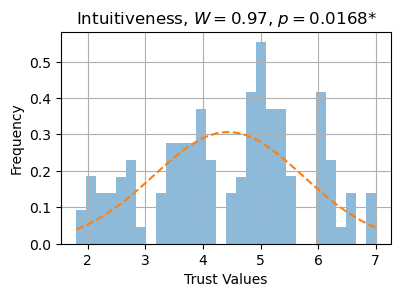

In [56]:
col = user_study2.filter(regex=r'(Q11|Q13|Q16|Q18)').columns
intuitive2 = user_study2.filter(regex=r'(Q11|Q13|Q16|Q18|Q19|mean2)')
intuitive2 = intuitive2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive2 = intuitive2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(intuitive2["mean2"].values, "Intuitiveness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_intuitiveness.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness

Non-intuitiveness ShapiroResult(statistic=0.9577966332435608, pvalue=0.001069863559678197)


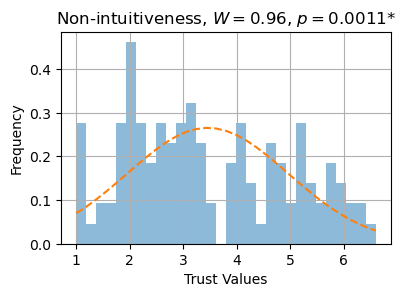

In [57]:
col = user_study2.filter(regex=r'(Q12|Q14|Q15|Q17)').columns
nonintuitive2 = user_study2.filter(regex=r'(Q12|Q14|Q15|Q17|Q19|mean2)')
nonintuitive2 = nonintuitive2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive2 = nonintuitive2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(nonintuitive2["mean2"].values, "Non-intuitiveness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_nonintuitiveness.pdf", bbox_inches='tight')
# plt.close()

## Faithfulness

Faithfulness ShapiroResult(statistic=0.968265175819397, pvalue=0.005901671480387449)


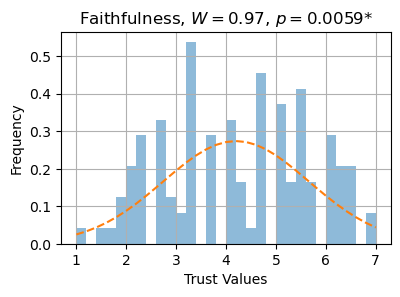

In [58]:
col = user_study2.filter(regex=r'(Q11|Q14|Q15|Q18)').columns
faithful2 = user_study2.filter(regex=r'(Q11|Q14|Q15|Q18|Q19|mean2)')
faithful2 = faithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
faithful2 = faithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(faithful2["mean2"].values, "Faithfulness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_faithfulness.pdf", bbox_inches='tight')
# plt.close()

## Unfaithfulness

Unfaithfulness ShapiroResult(statistic=0.9723381996154785, pvalue=0.01413970161229372)


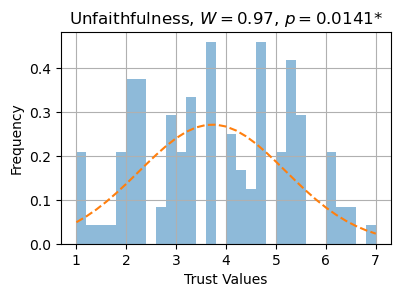

In [59]:
col = user_study2.filter(regex=r'(Q12|Q13|Q16|Q17)').columns
unfaithful2 = user_study2.filter(regex=r'(Q12|Q13|Q16|Q17|Q19|mean2)')
unfaithful2 = unfaithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
unfaithful2 = unfaithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(unfaithful2["mean2"].values, "Unfaithfulness", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_unfaithfulness.pdf", bbox_inches='tight')
# plt.close()

## Desired

Desired Features ShapiroResult(statistic=0.9642811417579651, pvalue=0.002836607163771987)


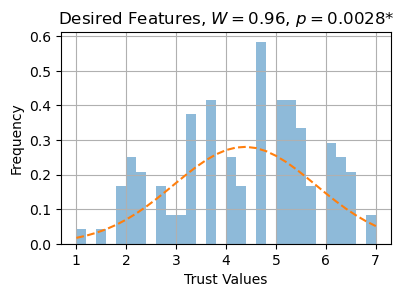

In [60]:
col = user_study2.filter(regex=r'(Q11|Q13|Q15|Q17)').columns
desired2 = user_study2.filter(regex=r'(Q11|Q13|Q15|Q17|Q19|mean2)')
desired2 = desired2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
desired2 = desired2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(desired2["mean2"].values, "Desired Features", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_desiredFeature.pdf", bbox_inches='tight')
# plt.close()

## Prohibited

Prohibited Features ShapiroResult(statistic=0.9744835495948792, pvalue=0.021221859380602837)


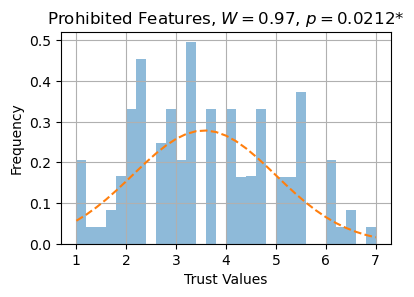

In [61]:
col = user_study2.filter(regex=r'(Q12|Q14|Q16|Q18)').columns
prohibited2 = user_study2.filter(regex=r'(Q12|Q14|Q16|Q18|Q19|mean2)')
prohibited2 = prohibited2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
prohibited2 = prohibited2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(prohibited2["mean2"].values, "Prohibited Features", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_prohibitedFeature.pdf", bbox_inches='tight')
# plt.close()

## Intuitiveness/Faithfulness

Intuitive/Faithful ShapiroResult(statistic=0.9750709533691406, pvalue=0.22078292071819305)


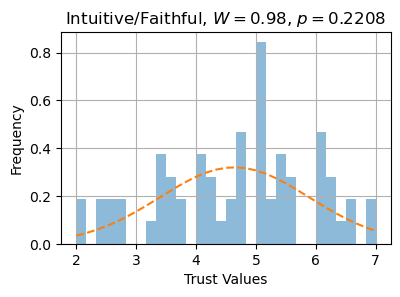

In [62]:
col = user_study2.filter(regex=r'(Q11|Q18)').columns
intuitive_faithful2 = user_study2.filter(regex=r'(Q11|Q18|Q19|mean2)')
intuitive_faithful2 = intuitive_faithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_faithful2 = intuitive_faithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(intuitive_faithful2["mean2"].values, "Intuitive/Faithful", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_IntuitiveFaithful.pdf", bbox_inches='tight')
# plt.close()

## Intuitiveness/Unfaithfulness

Intuitive/Unfaithful ShapiroResult(statistic=0.9719506502151489, pvalue=0.1739659607410431)


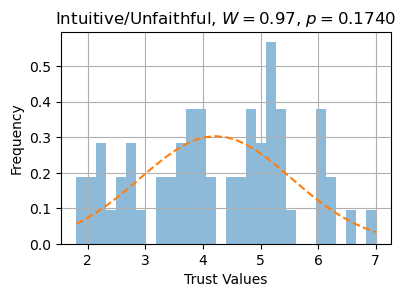

In [63]:
col = user_study2.filter(regex=r'(Q13|Q16)').columns
intuitive_unfaithful2 = user_study2.filter(regex=r'(Q13|Q16|Q19|mean2)')
intuitive_unfaithful2 = intuitive_unfaithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_unfaithful2 = intuitive_unfaithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(intuitive_unfaithful2["mean2"].values, "Intuitive/Unfaithful", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_IntuitiveUnfaithful.pdf", bbox_inches='tight')
# plt.close()

## Intuitiveness/Desired

Intuitive/Desired ShapiroResult(statistic=0.9501348733901978, pvalue=0.013546111062169075)


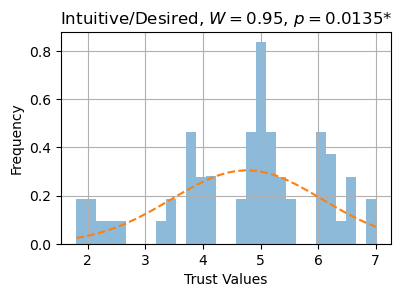

In [64]:
col = user_study2.filter(regex=r'(Q11|Q13)').columns
intuitive_desired2 = user_study2.filter(regex=r'(Q11|Q13|Q19|mean2)')
intuitive_desired2 = intuitive_desired2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_desired2 = intuitive_desired2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(intuitive_desired2["mean2"].values, "Intuitive/Desired", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_IntuitiveDesired.pdf", bbox_inches='tight')
# plt.close()

## Intuitiveness/Prohibited

Intuitive/Prohibited ShapiroResult(statistic=0.9724420309066772, pvalue=0.1689891368150711)


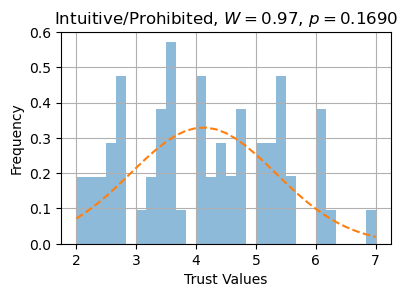

In [65]:
col = user_study2.filter(regex=r'(Q16|Q18)').columns
intuitive_prohibited2 = user_study2.filter(regex=r'(Q16|Q18|Q19|mean2)')
intuitive_prohibited2 = intuitive_prohibited2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_prohibited2 = intuitive_prohibited2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(intuitive_prohibited2["mean2"].values, "Intuitive/Prohibited", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_IntuitiveProhibited.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness/Faithfulness

Non-intuitive/Faithful ShapiroResult(statistic=0.9383596181869507, pvalue=0.006029136478900909)


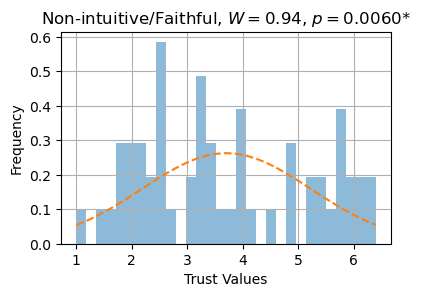

In [66]:
col = user_study2.filter(regex=r'(Q14|Q15)').columns
nonintuitive_faithful2 = user_study2.filter(regex=r'(Q14|Q15|Q19|mean2)')
nonintuitive_faithful2 = nonintuitive_faithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_faithful2 = nonintuitive_faithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(nonintuitive_faithful2["mean2"].values, "Non-intuitive/Faithful", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_NonintuitiveFaithful.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness/Unfaithfulness

Non-intuitive/Unfaithful ShapiroResult(statistic=0.9585521817207336, pvalue=0.042704518884420395)


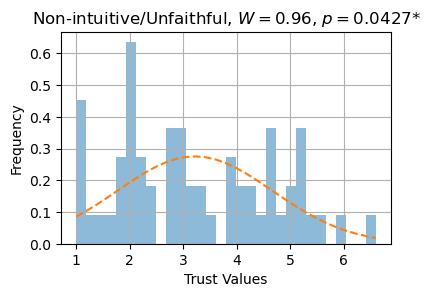

In [67]:
col = user_study2.filter(regex=r'(Q12|Q17)').columns
nonintuitive_unfaithful2 = user_study2.filter(regex=r'(Q12|Q17|Q19|mean2)')
nonintuitive_unfaithful2 = nonintuitive_unfaithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_unfaithful2 = nonintuitive_unfaithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(nonintuitive_unfaithful2["mean2"].values, "Non-intuitive/Unfaithful", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_NonintuitiveUnfaithful.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness/Desired

Non-intuitive/Desired ShapiroResult(statistic=0.9623124003410339, pvalue=0.06884510815143585)


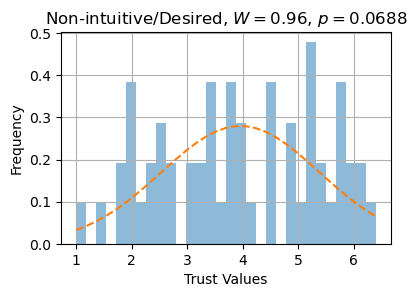

In [68]:
col = user_study2.filter(regex=r'(Q15|Q17)').columns
nonintuitive_desired2 = user_study2.filter(regex=r'(Q15|Q17|Q19|mean2)')
nonintuitive_desired2 = nonintuitive_desired2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_desired2 = nonintuitive_desired2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(nonintuitive_desired2["mean2"].values, "Non-intuitive/Desired", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_NonintuitiveDesired.pdf", bbox_inches='tight')
# plt.close()

## Non-intuitiveness/Prohibited

Non-intuitive/Prohibited ShapiroResult(statistic=0.9338323473930359, pvalue=0.003516351105645299)


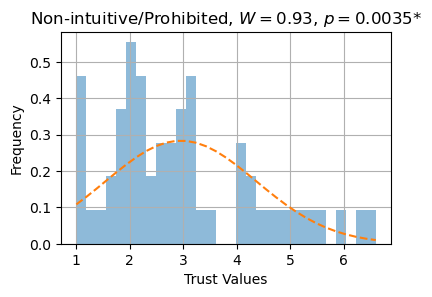

In [69]:
col = user_study2.filter(regex=r'(Q12|Q14)').columns
nonintuitive_prohibited2 = user_study2.filter(regex=r'(Q12|Q14|Q19|mean2)')
nonintuitive_prohibited2 = nonintuitive_prohibited2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_prohibited2 = nonintuitive_prohibited2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(nonintuitive_prohibited2["mean2"].values, "Non-intuitive/Prohibited", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_NonintuitiveProhibited.pdf", bbox_inches='tight')
# plt.close()

## Desired/Faithfulness

Faithful/Desired ShapiroResult(statistic=0.9490795135498047, pvalue=0.013035917654633522)


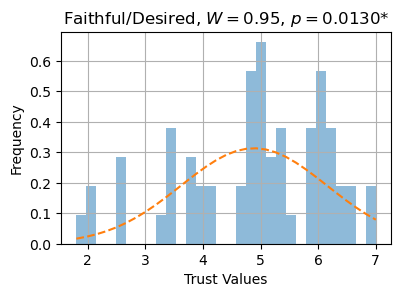

In [70]:
col = user_study2.filter(regex=r'(Q11|Q15)').columns
desired_faithful2 = user_study2.filter(regex=r'(Q11|Q15|Q19|mean2)')
desired_faithful2 = desired_faithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
desired_faithful2 = desired_faithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(desired_faithful2["mean2"].values, "Faithful/Desired", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_FaithfulDesired.pdf", bbox_inches='tight')
# plt.close()

## Desired/Unfaithfulness

Unfaithful/Desired ShapiroResult(statistic=0.9692404270172119, pvalue=0.14053481817245483)


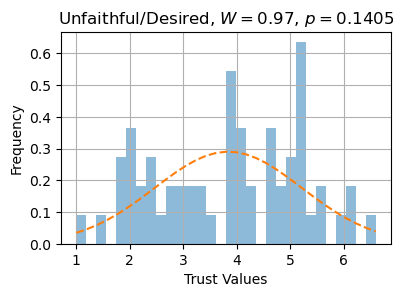

In [71]:
col = user_study2.filter(regex=r'(Q13|Q17)').columns
desired_unfaithful2 = user_study2.filter(regex=r'(Q13|Q17|Q19|mean2)')
desired_unfaithful2 = desired_unfaithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
desired_unfaithful2 = desired_unfaithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(desired_unfaithful2["mean2"].values, "Unfaithful/Desired", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_UnfaithfulDesired.pdf", bbox_inches='tight')
# plt.close()

## Prohibited/Faithfulness

Faithful/Prohibited ShapiroResult(statistic=0.9683803915977478, pvalue=0.12152335047721863)


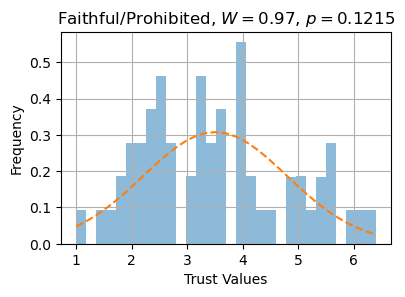

In [72]:
col = user_study2.filter(regex=r'(Q14|Q18)').columns
prohibited_faithful2 = user_study2.filter(regex=r'(Q14|Q18|Q19|mean2)')
prohibited_faithful2 = prohibited_faithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
prohibited_faithful2 = prohibited_faithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(prohibited_faithful2["mean2"].values, "Faithful/Prohibited", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_FaithfulProhibited.pdf", bbox_inches='tight')
# plt.close()

## Prohibited/Unfaithfulness

Unfaithful/Prohibited ShapiroResult(statistic=0.9684484601020813, pvalue=0.11654140800237656)


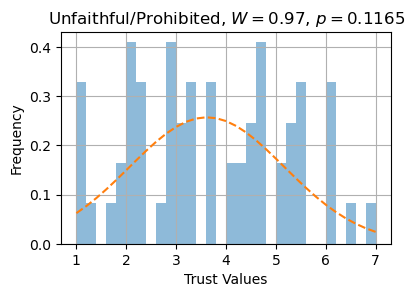

In [73]:
col = user_study2.filter(regex=r'(Q12|Q16)').columns
prohibited_unfaithful2 = user_study2.filter(regex=r'(Q12|Q16|Q19|mean2)')
prohibited_unfaithful2 = prohibited_unfaithful2.dropna(subset=col, axis = 0, how = 'all', inplace = False)
prohibited_unfaithful2 = prohibited_unfaithful2.dropna(axis = 1, how = 'all', inplace = False)

fig = plot_distribution(prohibited_unfaithful2["mean2"].values, "Unfaithful/Prohibited", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_UnfaithfulProhibited.pdf", bbox_inches='tight')
# plt.close()

## Condition 1 - Intuitiveness/Faithfulness/Desired

34
Condition 1 ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Q11.4$|Q11.10$|Q11.16$|Q11.22$|Q11.28$|Q11.35$|Q11.43


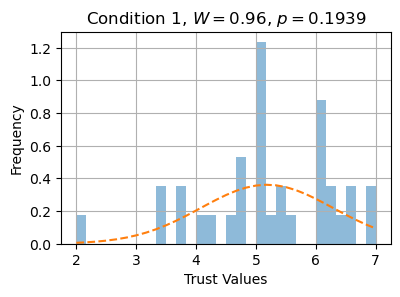

In [74]:
col = user_study2.filter(regex=r'(Q11)').columns
intuitive_faithful_desired1 = user_study2.filter(regex=r'(Q11|Q19|mean2)')
intuitive_faithful_desired1 = intuitive_faithful_desired1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_faithful_desired1 = intuitive_faithful_desired1.dropna(axis = 1, how = 'all', inplace = False)
print(len(intuitive_faithful_desired1.index))
# intuitive_faithful_desired1

fig = plot_distribution(intuitive_faithful_desired1["mean2"].values, "Condition 1", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition1.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[0])
print(predictions)
predictions_mean1 = intuitive_faithful_desired1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean1 = predictions_mean1[~np.isnan(predictions_mean1)]
# predictions_mean1

## Condition 2 - Inutitiveness/Unfaithfulness/Desired

28
Condition 2 ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Q13.4$|Q13.10$|Q13.16$|Q13.22$|Q13.28$|Q13.35$|Q13.43


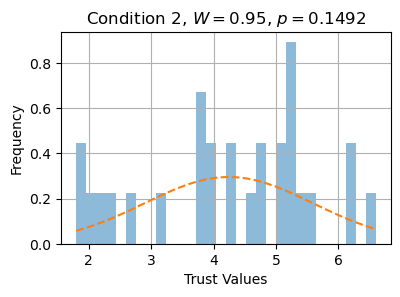

In [75]:
col = user_study2.filter(regex=r'(Q13)').columns
intuitive_unfaithful_desired1 = user_study2.filter(regex=r'(Q13|Q19|mean2)')
intuitive_unfaithful_desired1 = intuitive_unfaithful_desired1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_unfaithful_desired1 = intuitive_unfaithful_desired1.dropna(axis = 1, how = 'all', inplace = False)
print(len(intuitive_unfaithful_desired1.index))
# intuitive_unfaithful_desired1

fig = plot_distribution(intuitive_unfaithful_desired1["mean2"].values, "Condition 2", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition2.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[2])
print(predictions)
predictions_mean2 = intuitive_unfaithful_desired1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean2 = predictions_mean2[~np.isnan(predictions_mean2)]
# predictions_mean2

## Condition 3 - Intuitiveness/Faithfulness/Prohibited

30
Condition 3 ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Q18.4$|Q18.10$|Q18.16$|Q18.22$|Q18.28$|Q18.35$|Q18.43


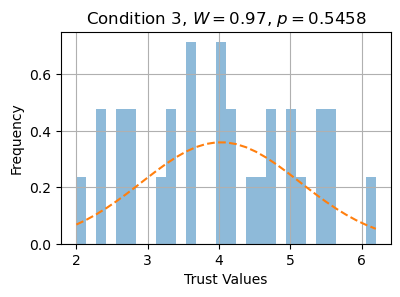

In [76]:
col = user_study2.filter(regex=r'(Q18)').columns
intuitive_faithful_prohibited1 = user_study2.filter(regex=r'(Q18|Q19|mean2)')
intuitive_faithful_prohibited1 = intuitive_faithful_prohibited1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_faithful_prohibited1 = intuitive_faithful_prohibited1.dropna(axis = 1, how = 'all', inplace = False)
print(len(intuitive_faithful_prohibited1.index))
# intuitive_faithful_prohibited1

fig = plot_distribution(intuitive_faithful_prohibited1["mean2"].values, "Condition 3", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition3.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[7])
print(predictions)
predictions_mean3 = intuitive_faithful_prohibited1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean3 = predictions_mean3[~np.isnan(predictions_mean3)]
# predictions_mean3

## Condition 4 - Intuitiveness/Unfaithfulness/Prohibited

33
Condition 4 ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Q16.4$|Q16.10$|Q16.16$|Q16.22$|Q16.28$|Q16.35$|Q16.43


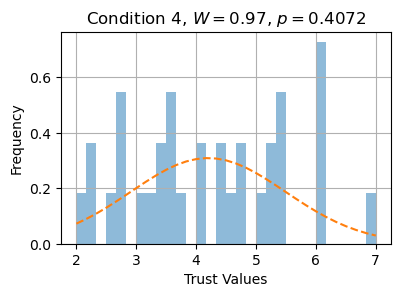

In [77]:
col = user_study2.filter(regex=r'(Q16)').columns
intuitive_unfaithful_prohibited1 = user_study2.filter(regex=r'(Q16|Q19|mean2)')
intuitive_unfaithful_prohibited1 = intuitive_unfaithful_prohibited1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
intuitive_unfaithful_prohibited1 = intuitive_unfaithful_prohibited1.dropna(axis = 1, how = 'all', inplace = False)
print(len(intuitive_unfaithful_prohibited1.index))
# intuitive_unfaithful_prohibited1

fig = plot_distribution(intuitive_unfaithful_prohibited1["mean2"].values, "Condition 4", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition4.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[5])
print(predictions)
predictions_mean4 = intuitive_unfaithful_prohibited1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean4 = predictions_mean4[~np.isnan(predictions_mean4)]
# predictions_mean4

## Condition 5 - Non-intuitiveness/Faithfulness/Desired

27
Condition 5 ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Q15.4$|Q15.10$|Q15.16$|Q15.22$|Q15.28$|Q15.35$|Q15.43


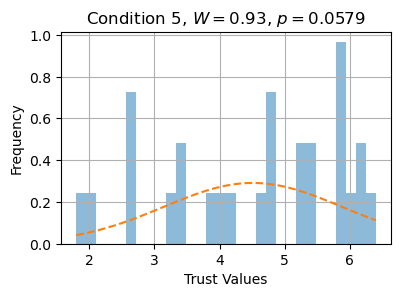

In [78]:
col = user_study2.filter(regex=r'(Q15)').columns
nonintuitive_faithful_desired1 = user_study2.filter(regex=r'(Q15|Q19|mean2)')
nonintuitive_faithful_desired1 = nonintuitive_faithful_desired1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_faithful_desired1 = nonintuitive_faithful_desired1.dropna(axis = 1, how = 'all', inplace = False)
print(len(nonintuitive_faithful_desired1.index))
# nonintuitive_faithful_desired1

fig = plot_distribution(nonintuitive_faithful_desired1["mean2"].values, "Condition 5", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition5.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[4])
print(predictions)
predictions_mean5 = nonintuitive_faithful_desired1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean5 = predictions_mean5[~np.isnan(predictions_mean5)]
# predictions_mean5

## Condition 6 - Non-intuitiveness/Unfaithfulness/Desired

31
Condition 6 ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Q17.4$|Q17.10$|Q17.16$|Q17.22$|Q17.28$|Q17.35$|Q17.43


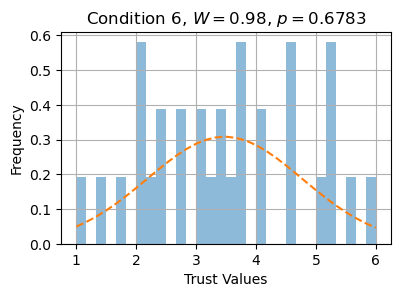

In [79]:
col = user_study2.filter(regex=r'(Q17)').columns
nonintuitive_unfaithful_desired1 = user_study2.filter(regex=r'(Q17|Q19|mean2)')
nonintuitive_unfaithful_desired1 = nonintuitive_unfaithful_desired1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_unfaithful_desired1 = nonintuitive_unfaithful_desired1.dropna(axis = 1, how = 'all', inplace = False)
print(len(nonintuitive_unfaithful_desired1.index))
# nonintuitive_unfaithful_desired1

fig = plot_distribution(nonintuitive_unfaithful_desired1["mean2"].values, "Condition 6", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition6.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[6])
print(predictions)
predictions_mean6 = nonintuitive_unfaithful_desired1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean6 = predictions_mean6[~np.isnan(predictions_mean6)]
# predictions_mean6

## Condition 7 - Non-intuitiveness/Faithfulness/Prohibited

30
Condition 7 ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
Q14.4$|Q14.10$|Q14.16$|Q14.22$|Q14.28$|Q14.35$|Q14.43


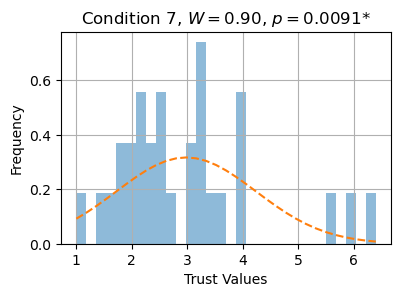

In [80]:
col = user_study2.filter(regex=r'(Q14)').columns
nonintuitive_faithful_prohibited1 = user_study2.filter(regex=r'(Q14|Q19|mean2)')
nonintuitive_faithful_prohibited1 = nonintuitive_faithful_prohibited1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_faithful_prohibited1 = nonintuitive_faithful_prohibited1.dropna(axis = 1, how = 'all', inplace = False)
print(len(nonintuitive_faithful_prohibited1.index))
# nonintuitive_faithful_prohibited1

fig = plot_distribution(nonintuitive_faithful_prohibited1["mean2"].values, "Condition 7", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition7.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[3])
print(predictions)
predictions_mean7 = nonintuitive_faithful_prohibited1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean7 = predictions_mean7[~np.isnan(predictions_mean7)]
# predictions_mean7

## Condition 8 - Non-intuitiveness/Unfaithfulness/Prohibited

28
Condition 8 ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
Q12.4$|Q12.10$|Q12.16$|Q12.22$|Q12.28$|Q12.35$|Q12.43


array([0.4       , 0.4       , 0.4       , 0.4       , 0.        ,
       0.4       , 0.6       , 0.42857143, 0.4       , 0.4       ,
       0.6       , 0.4       , 0.4       , 0.4       , 0.6       ,
       0.2       , 0.6       , 0.28571429, 0.4       , 0.6       ,
       0.28571429, 0.6       , 0.4       , 0.4       , 0.4       ,
       0.2       , 0.4       , 0.4       ])

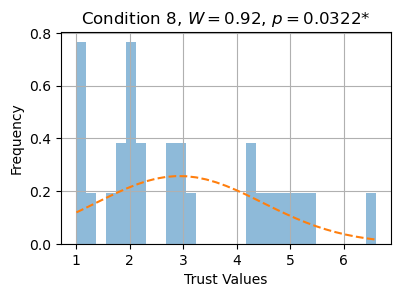

In [81]:
col = user_study2.filter(regex=r'(Q12)').columns
nonintuitive_unfaithful_prohibited1 = user_study2.filter(regex=r'(Q12|Q19|mean2)')
nonintuitive_unfaithful_prohibited1 = nonintuitive_unfaithful_prohibited1.dropna(subset=col, axis = 0, how = 'all', inplace = False)
nonintuitive_unfaithful_prohibited1 = nonintuitive_unfaithful_prohibited1.dropna(axis = 1, how = 'all', inplace = False)
print(len(nonintuitive_unfaithful_prohibited1.index))
# nonintuitive_unfaithful_prohibited1

fig = plot_distribution(nonintuitive_unfaithful_prohibited1["mean2"].values, "Condition 8", figsize=(4.25,2.75))
# fig.savefig(f"./result_imgs/study2/distribution_condition8.pdf", bbox_inches='tight')
# plt.close()

predictions = "$|".join(questions2[1])
print(predictions)
predictions_mean8 = nonintuitive_unfaithful_prohibited1.filter(regex=r'%s' %(predictions)).mean(axis=1).values
predictions_mean8 = predictions_mean8[~np.isnan(predictions_mean8)]
predictions_mean8

## Prediction Alignment

In [82]:
intuitive = np.concatenate((predictions_mean1, predictions_mean2, predictions_mean3, predictions_mean4))
nonintuitive = np.concatenate((predictions_mean5, predictions_mean6, predictions_mean7, predictions_mean8))
print(np.median(intuitive))
print(np.median(nonintuitive))
print(testing(intuitive, nonintuitive, 'two-sided'))

0.4
0.4
Sample a:  ShapiroResult(statistic=0.8727657794952393, pvalue=5.91886317735657e-09)
Sample b:  ShapiroResult(statistic=0.9280408620834351, pvalue=1.0066075446957257e-05)
RanksumsResult(statistic=2.8404696588042677, pvalue=0.004504715797690182)


Intuitiveness ShapiroResult(statistic=0.8727657794952393, pvalue=5.91886317735657e-09)
Non-intuitiveness ShapiroResult(statistic=0.9280408620834351, pvalue=1.0066075446957257e-05)


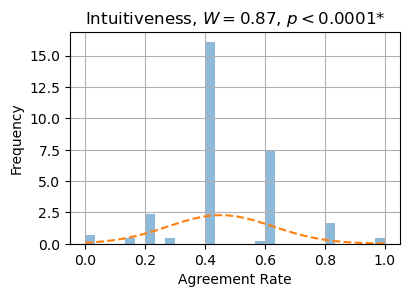

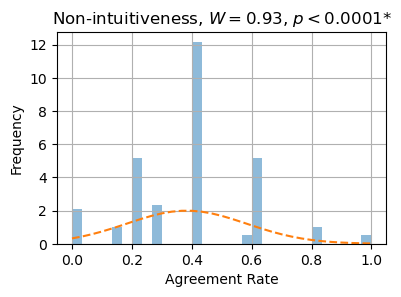

In [83]:
datas = [intuitive, nonintuitive]
names = ["Intuitiveness", "Non-intuitiveness"]
for i, data in enumerate(datas):
    fig = plot_distribution(data, names[i], xlabel="Agreement Rate", figsize=(4.25,2.75), xticks=np.arange(0, 1.2, 0.2))
#     fig.savefig(f"./result_imgs/study2/prediction_alignment_{names[i]}.pdf", bbox_inches='tight')
#     plt.close()

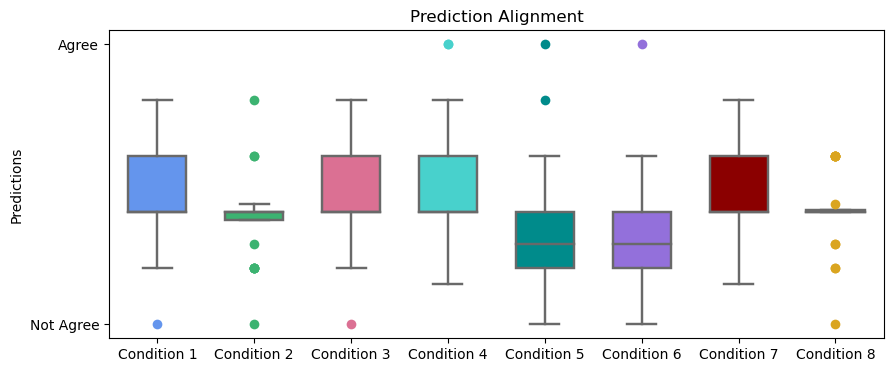

In [84]:
colors = ['cornflowerblue', 'mediumseagreen', 'palevioletred', 'mediumturquoise',
          'darkcyan', 'mediumpurple', 'darkred', 'goldenrod']
tables = [predictions_mean1, predictions_mean2, predictions_mean3, predictions_mean4,
          predictions_mean5, predictions_mean6, predictions_mean7, predictions_mean8]
x_ticks = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 
           'Condition 5', 'Condition 6', 'Condition 7', 'Condition 8']
y_ticks = ['Not Agree', 'Agree']
ylabel = "Predictions"
title= "Prediction Alignment"
fig = plot_boxplot(tables=tables, colors=colors, xticks=x_ticks, 
                   yticks=np.arange(len(y_ticks)), ylabel=ylabel, title=title, yticks_labels=y_ticks, figsize=(10,4))
# fig.savefig(f"./result_imgs/study2/prediction_alignment.pdf", bbox_inches='tight')
# # plt.close()

# ----------------------------------------------------------------------------------------------
# Subjective User Trust

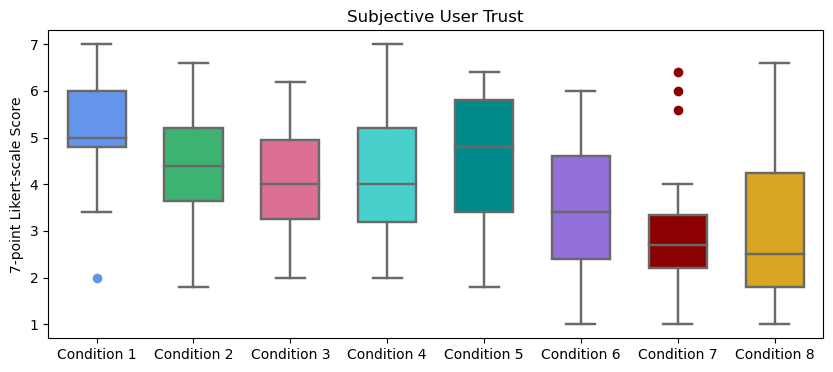

In [85]:
tables = [intuitive_faithful_desired1, intuitive_unfaithful_desired1, 
          intuitive_faithful_prohibited1, intuitive_unfaithful_prohibited1,
          nonintuitive_faithful_desired1, nonintuitive_unfaithful_desired1,
          nonintuitive_faithful_prohibited1, nonintuitive_unfaithful_prohibited1]
x_ticks = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 
           'Condition 5', 'Condition 6', 'Condition 7', 'Condition 8']
y_ticks = np.arange(1,7+1)
ylabel = "7-point Likert-scale Score"
title= "Subjective User Trust"
fig = plot_boxplot(tables, colors, x_ticks, y_ticks, ylabel, title=title, regex=r'(mean2)', figsize=(10,4))
# fig.savefig(f"./result_imgs/study2/us2_user_trust.pdf", bbox_inches='tight')

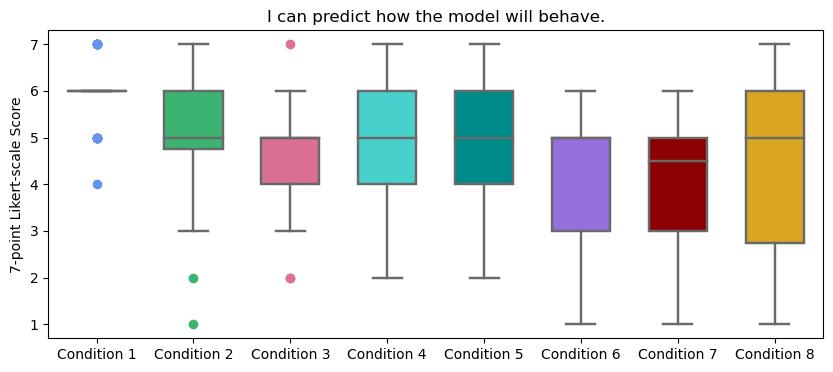

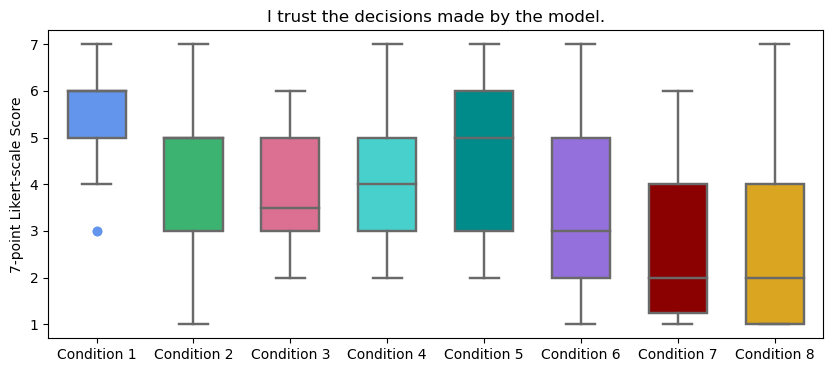

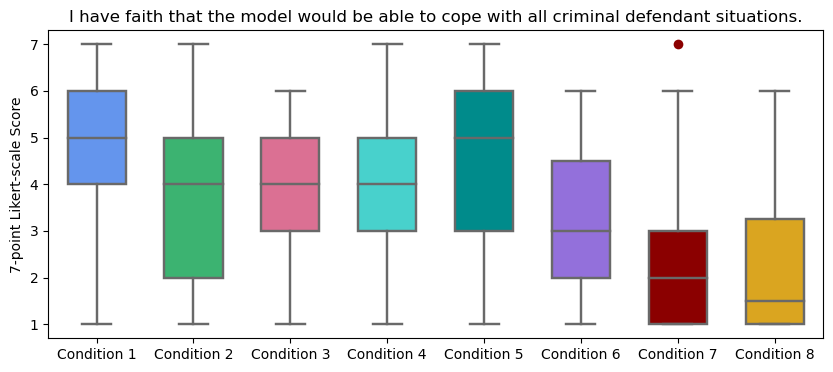

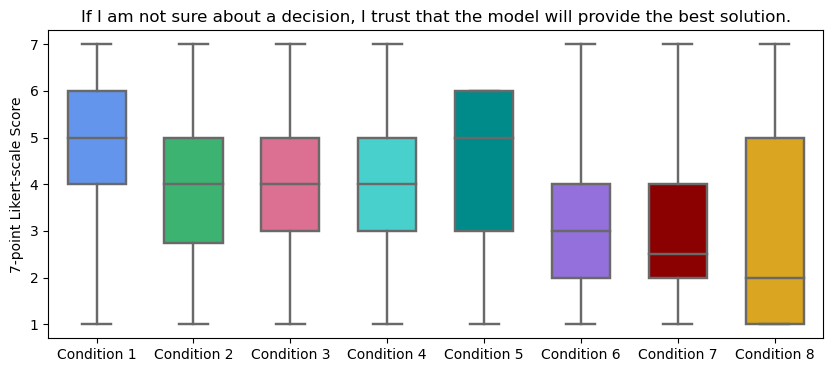

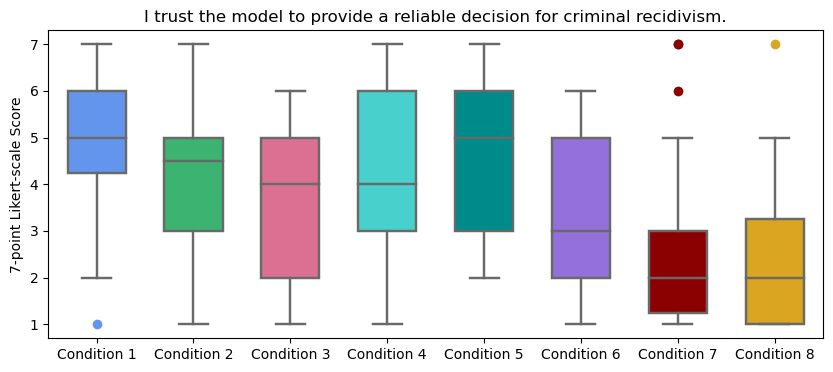

In [86]:
questions_us2 = ['I can predict how the model will behave.',
                 'I trust the decisions made by the model.',
                 'I have faith that the model would be able to cope with all criminal defendant situations.',
                 'If I am not sure about a decision, I trust that the model will provide the best solution.',
                 'I trust the model to provide a reliable decision for criminal recidivism.']

for j in range(0, 5):
    title = questions_us2[j]
    fig = plot_boxplot(tables, colors, x_ticks, y_ticks, ylabel, title=title, regex=r'(Q19.1_%s)' % (j+1), figsize=(10,4))
#     fig.savefig(f"./result_imgs/study2/us2_user_trust_question{j+1}.pdf", bbox_inches='tight')
#     plt.close()

## Likert-scale User Judgement

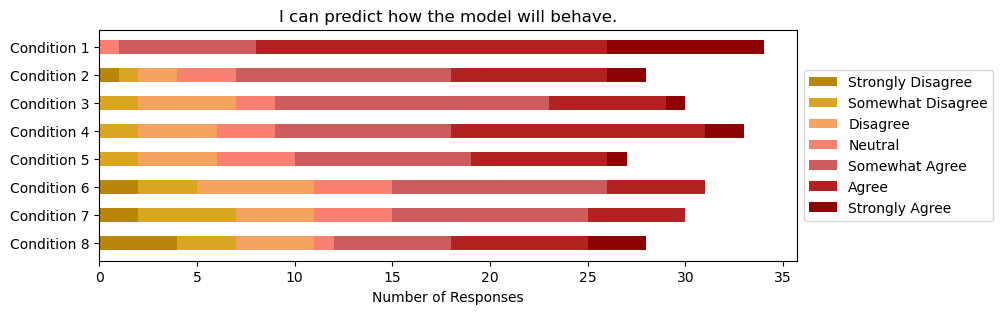

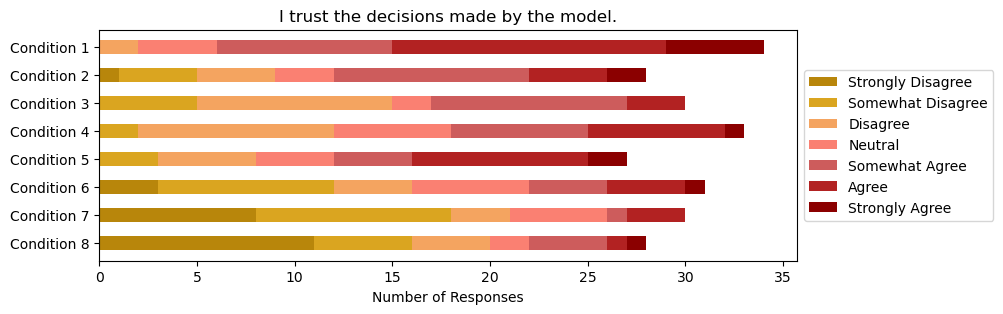

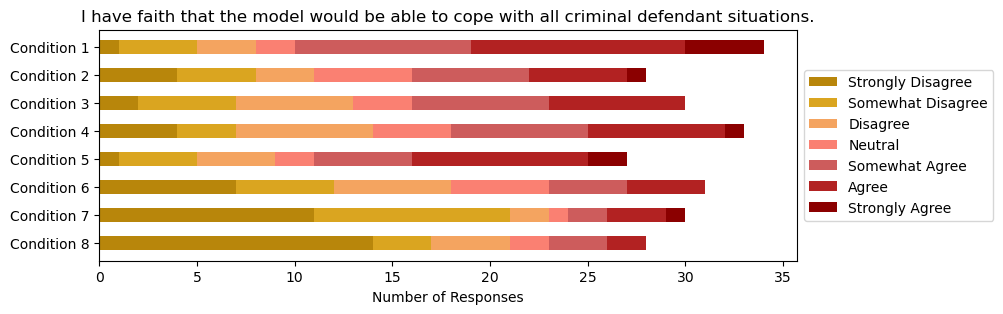

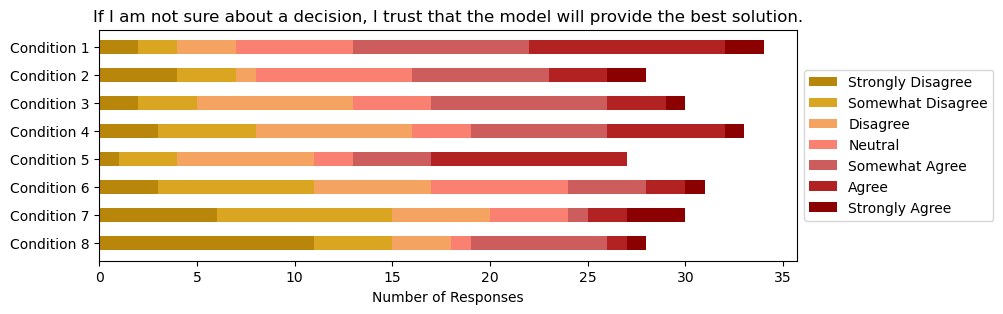

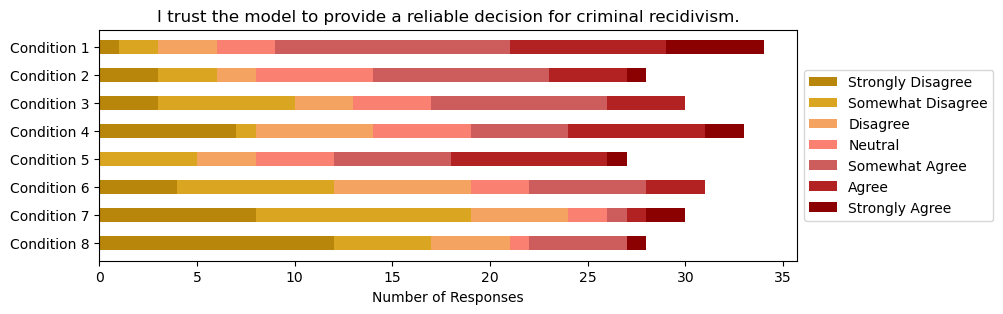

In [87]:
colors = ['darkgoldenrod', 'goldenrod', 'sandybrown', "salmon", "indianred", "firebrick", "darkred"]
data = np.zeros((8, 5, 7))

# Define the categories for the Likert scale
categories = ['Strongly Disagree', 'Somewhat Disagree', 'Disagree', 'Neutral', 'Somewhat Agree', 'Agree', 'Strongly Agree']
tables = [intuitive_faithful_desired1, intuitive_unfaithful_desired1, 
          intuitive_faithful_prohibited1, intuitive_unfaithful_prohibited1,
          nonintuitive_faithful_desired1, nonintuitive_unfaithful_desired1,
          nonintuitive_faithful_prohibited1, nonintuitive_unfaithful_prohibited1]

for i, table in enumerate(tables):
    trust = table.filter(regex='Q19.1_')
    for t, col in enumerate(trust.columns):
        score = list(trust[col].values)
        for l in range(1, 7+1):
            data[i, t, l-1] = score.count(l)
            
labels = ['Condition 1', 'Condition 2', 'Condition 3', 'Condition 4',
          'Condition 5', 'Condition 6', 'Condition 7', 'Condition 8']
for j in range(0, 5):
    fig = plot_barplot(data, colors, labels, categories, questions_us2[j], figsize=(9,3))
#     fig.savefig(f"./result_imgs/study2/questions_trust_counts{j+1}.pdf", bbox_inches='tight')
#     plt.close()

#  ----------------------------------------------------------------------------------------------------------
## Testing Hypothesis H1

### intuitive <-> non-intuitive

Sample a:  ShapiroResult(statistic=0.9741288423538208, pvalue=0.016772786155343056)
Sample b:  ShapiroResult(statistic=0.9577966332435608, pvalue=0.001069863559678197)
RanksumsResult(statistic=4.989314543915309, pvalue=3.0296957340817475e-07)


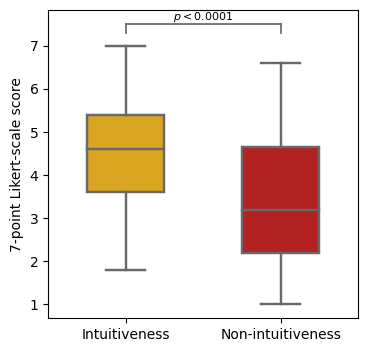

In [88]:
res = testing(intuitive2["mean2"].values, nonintuitive2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[intuitive2["mean2"].values, nonintuitive2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitiveness', 'Non-intuitiveness'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H1_result3.pdf", bbox_inches='tight')

In [89]:
print(intuitive2["mean2"].median())
print(nonintuitive2["mean2"].median())

4.6
3.2


### intuitive/faithful (Condition 1 and 3) <-> non-intuitive/faithful (Condition 5 and 7)

Sample a:  ShapiroResult(statistic=0.9750709533691406, pvalue=0.22078292071819305)
Sample b:  ShapiroResult(statistic=0.9383596181869507, pvalue=0.006029136478900909)
RanksumsResult(statistic=3.3985443659251153, pvalue=0.0003387273711338516)


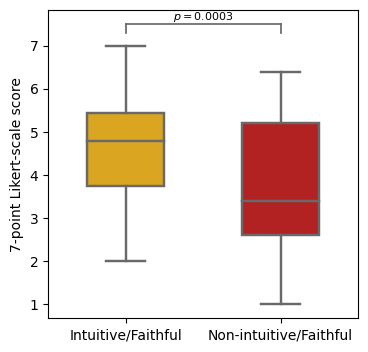

In [90]:
res = testing(intuitive_faithful2["mean2"].values, nonintuitive_faithful2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_faithful2["mean2"].values, nonintuitive_faithful2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitive/Faithful', 'Non-intuitive/Faithful'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H1_result1.pdf", bbox_inches='tight')

In [91]:
print(intuitive_faithful2["mean2"].median())
print(nonintuitive_faithful2["mean2"].median())

4.8
3.4


### intuitive/unfaithful (Condition 2 and 4) <-> non-intuitive/unfaithful (6 and 8)

Sample a:  ShapiroResult(statistic=0.9719506502151489, pvalue=0.1739659607410431)
Sample b:  ShapiroResult(statistic=0.9585521817207336, pvalue=0.042704518884420395)
RanksumsResult(statistic=3.645686034561194, pvalue=0.00013333970445001374)


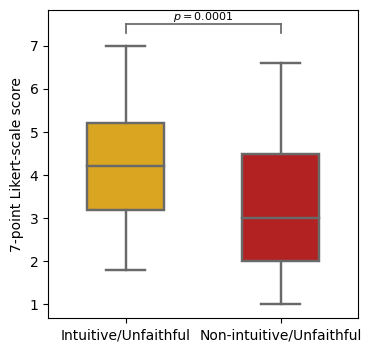

In [92]:
res = testing(intuitive_unfaithful2["mean2"].values, nonintuitive_unfaithful2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_unfaithful2["mean2"].values, nonintuitive_unfaithful2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitive/Unfaithful', 'Non-intuitive/Unfaithful'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H1_result2.pdf", bbox_inches='tight')

In [93]:
print(intuitive_unfaithful2["mean2"].median())
print(nonintuitive_unfaithful2["mean2"].median())

4.2
3.0


## Testing Hypothesis H2

### Faithful (Condition 1, 3, 5 and 7) <-> Unfaithful (Condition 2, 4, 6 and 8)

Sample a:  ShapiroResult(statistic=0.968265175819397, pvalue=0.005901671480387449)
Sample b:  ShapiroResult(statistic=0.9723381996154785, pvalue=0.01413970161229372)
RanksumsResult(statistic=2.3876031627518413, pvalue=0.016958642435521688)


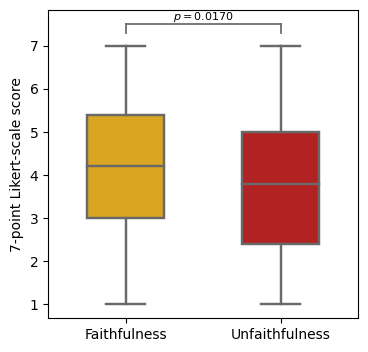

In [94]:
res = testing(faithful2["mean2"].values, unfaithful2["mean2"].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[faithful2["mean2"].values, unfaithful2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Faithfulness', 'Unfaithfulness'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H2_result1.pdf", bbox_inches='tight')

In [95]:
print(faithful2["mean2"].median())
print(unfaithful2["mean2"].median())

4.2
3.8


### Intuitive/Faithful (Condition 1 and 3) <-> Intuitive/Unfaithful (Condition 2 and 4)

Sample a:  ShapiroResult(statistic=0.9750709533691406, pvalue=0.22078292071819305)
Sample b:  ShapiroResult(statistic=0.9719506502151489, pvalue=0.1739659607410431)
Ttest_indResult(statistic=1.8189266849295256, pvalue=0.07135529994598416)


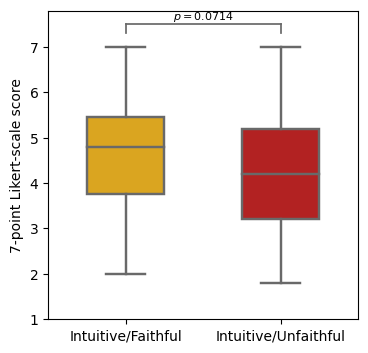

In [96]:
res = testing(intuitive_faithful2['mean2'].values, intuitive_unfaithful2['mean2'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_faithful2['mean2'].values, intuitive_unfaithful2['mean2'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitive/Faithful', 'Intuitive/Unfaithful'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H2_result2.pdf", bbox_inches='tight')

In [97]:
print(len(intuitive_faithful2['mean2'].values), len(intuitive_unfaithful2['mean2'].values))
print(intuitive_faithful2['mean2'].mean())
print(intuitive_faithful2['mean2'].std())
print(intuitive_unfaithful2['mean2'].mean())
print(intuitive_unfaithful2['mean2'].std())

64 61
4.640625000000001
1.2579548468945123
4.219672131147541
1.3295136544530293


### Non-intuitive/Faithful (Condition 5 and 7) <-> Non-intuitive/Unfaithful (Condition 6 and 8)

Sample a:  ShapiroResult(statistic=0.9383596181869507, pvalue=0.006029136478900909)
Sample b:  ShapiroResult(statistic=0.9585521817207336, pvalue=0.042704518884420395)
RanksumsResult(statistic=1.6981630174929172, pvalue=0.08947699843165347)


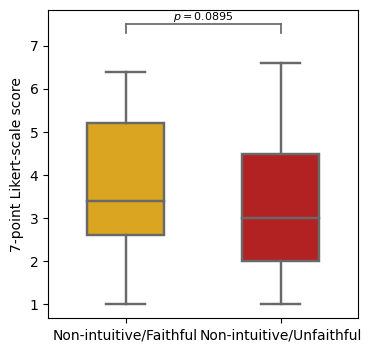

In [98]:
res = testing(nonintuitive_faithful2['mean2'].values, nonintuitive_unfaithful2['mean2'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[nonintuitive_faithful2['mean2'].values, nonintuitive_unfaithful2['mean2'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Non-intuitive/Faithful', 'Non-intuitive/Unfaithful'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H2_result3.pdf", bbox_inches='tight')

In [99]:
print(nonintuitive_faithful2['mean2'].median())
print(nonintuitive_unfaithful2['mean2'].median())

3.4
3.0


### Desired/Faithful (Condition 1 and 5) <-> Desired/Unfaithful (Condition 2 and 6)

Sample a:  ShapiroResult(statistic=0.9490795135498047, pvalue=0.013035917654633522)
Sample b:  ShapiroResult(statistic=0.9692404270172119, pvalue=0.14053481817245483)
RanksumsResult(statistic=3.9501493751005015, pvalue=7.810243469676565e-05)


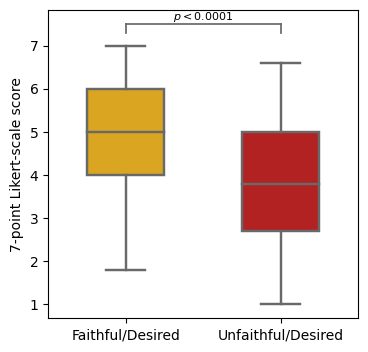

In [100]:
res = testing(desired_faithful2['mean2'].values, desired_unfaithful2['mean2'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[desired_faithful2['mean2'].values, desired_unfaithful2['mean2'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Faithful/Desired', 'Unfaithful/Desired'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H2_result4.pdf", bbox_inches='tight')

In [101]:
print(desired_faithful2['mean2'].median())
print(desired_unfaithful2['mean2'].median())

5.0
3.8


### Prohibited/Faithful (Condition 3 and 7) <-> Prohibited/Unfaithful (Condition 4 and 8)

Sample a:  ShapiroResult(statistic=0.9683803915977478, pvalue=0.12152335047721863)
Sample b:  ShapiroResult(statistic=0.9684484601020813, pvalue=0.11654140800237656)
Ttest_indResult(statistic=-0.43074459538241505, pvalue=0.6674332785528193)


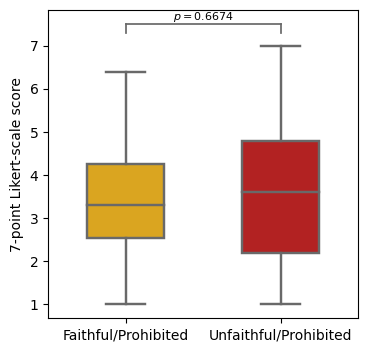

In [102]:
res = testing(prohibited_faithful2['mean2'].values, prohibited_unfaithful2['mean2'].values, 'two-sided')
print(res)
fig = plot_boxplot_testing(tables=[prohibited_faithful2['mean2'].values, prohibited_unfaithful2['mean2'].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Faithful/Prohibited', 'Unfaithful/Prohibited'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H2_result5.pdf", bbox_inches='tight')

In [103]:
print(len(prohibited_faithful2['mean2'].values), len(prohibited_unfaithful2['mean2'].values))
print(prohibited_faithful2['mean2'].mean())
print(prohibited_faithful2['mean2'].std())
print(prohibited_unfaithful2['mean2'].mean())
print(prohibited_unfaithful2['mean2'].std())

60 61
3.503333333333333
1.3078597689130294
3.6163934426229503
1.565586187116384


### Intuitive/Faithful/Desired (Condition 1) <-> Intuitive/Desired/Unfaithful (Condition 2)

In [104]:
testing(intuitive_faithful_desired1['mean2'].values, intuitive_unfaithful_desired1['mean2'].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)


Ttest_indResult(statistic=2.965656785711339, pvalue=0.004330005629495813)

In [105]:
print(len(intuitive_faithful_desired1['mean2'].values), len(intuitive_unfaithful_desired1['mean2'].values))
print(intuitive_faithful_desired1['mean2'].mean())
print(intuitive_faithful_desired1['mean2'].std())
print(intuitive_unfaithful_desired1['mean2'].mean())
print(intuitive_unfaithful_desired1['mean2'].std())

34 28
5.182352941176471
1.1210034974765797
4.242857142857143
1.3742145423716083


### Intuitive/Faithful/Prohibited (Condition 3) <-> Intuitive/Unfaithful/Prohibited (Condition 4)

In [106]:
testing(intuitive_faithful_prohibited1['mean2'].values, intuitive_unfaithful_prohibited1['mean2'].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Sample b:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)


Ttest_indResult(statistic=-0.559565298892347, pvalue=0.5778249253649386)

In [107]:
print(len(intuitive_faithful_prohibited1['mean2'].values), len(intuitive_unfaithful_prohibited1['mean2'].values))
print(intuitive_faithful_prohibited1['mean2'].mean())
print(intuitive_faithful_prohibited1['mean2'].std())
print(intuitive_unfaithful_prohibited1['mean2'].mean())
print(intuitive_unfaithful_prohibited1['mean2'].std())

30 33
4.026666666666667
1.128604060969471
4.200000000000001
1.3114877048604


### Non-intuitive/Faitfhul/Desired (Condition 5) <-> Non-intuitive/Unfaithful/Desired (Condition 6)

In [108]:
testing(nonintuitive_faithful_desired1['mean2'].values, nonintuitive_unfaithful_desired1['mean2'].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)


Ttest_indResult(statistic=2.9016362692321467, pvalue=0.005298252073211345)

In [109]:
print(len(nonintuitive_faithful_desired1['mean2'].values), len(nonintuitive_unfaithful_desired1['mean2'].values))
print(nonintuitive_faithful_desired1['mean2'].mean())
print(nonintuitive_faithful_desired1['mean2'].std())
print(nonintuitive_unfaithful_desired1['mean2'].mean())
print(nonintuitive_unfaithful_desired1['mean2'].std())

27 31
4.511111111111112
1.3948623679922783
3.4774193548387093
1.316234446548019


### Non-intuitive/Faithful/Prohibited (Condition 7) <-> Non-intuitive/Unfaithful/Prohibited (Condition 8)

In [110]:
testing(nonintuitive_faithful_prohibited1['mean2'].values, nonintuitive_unfaithful_prohibited1['mean2'].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)


RanksumsResult(statistic=0.5368390130271741, pvalue=0.5913788207741724)

In [111]:
print(nonintuitive_faithful_prohibited1['mean2'].median())
print(nonintuitive_unfaithful_prohibited1['mean2'].median())

2.7
2.5


## Testing Hypothesis H3

### desired <-> prohibited

Sample a:  ShapiroResult(statistic=0.9642811417579651, pvalue=0.002836607163771987)
Sample b:  ShapiroResult(statistic=0.9744835495948792, pvalue=0.021221859380602837)
RanksumsResult(statistic=4.176457544751673, pvalue=1.4804198648644972e-05)


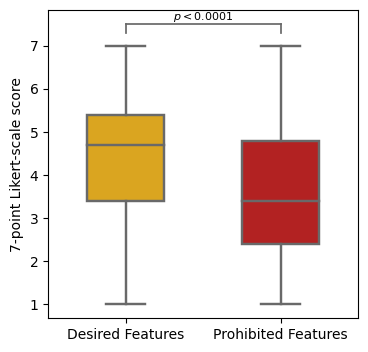

In [112]:
res = testing(desired2["mean2"].values, prohibited2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[desired2["mean2"].values, prohibited2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Desired Features', 'Prohibited Features'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H3_result3.pdf", bbox_inches='tight')

In [113]:
print(desired2["mean2"].median())
print(prohibited2["mean2"].median())

4.699999999999999
3.4


### desired/intuitive <-> prohibited/intuitive

Sample a:  ShapiroResult(statistic=0.9501348733901978, pvalue=0.013546111062169075)
Sample b:  ShapiroResult(statistic=0.9724420309066772, pvalue=0.1689891368150711)
RanksumsResult(statistic=2.8293967670501603, pvalue=0.0023317921357496624)


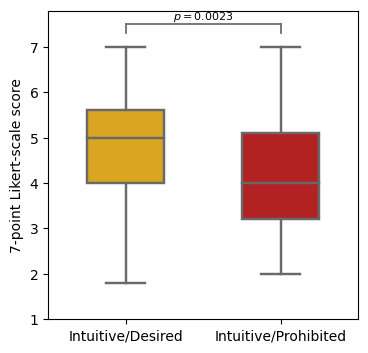

In [114]:
res = testing(intuitive_desired2["mean2"].values, intuitive_prohibited2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[intuitive_desired2["mean2"].values, intuitive_prohibited2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Intuitive/Desired', 'Intuitive/Prohibited'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H3_result4.pdf", bbox_inches='tight')

In [115]:
print(intuitive_desired2["mean2"].median())
print(intuitive_prohibited2["mean2"].median())

5.0
4.0


### non-intuitive/desired <-> non-intuitive/prohibited

Sample a:  ShapiroResult(statistic=0.9623124003410339, pvalue=0.06884510815143585)
Sample b:  ShapiroResult(statistic=0.9338323473930359, pvalue=0.003516351105645299)
RanksumsResult(statistic=3.6360134234706853, pvalue=0.00013844495454186888)


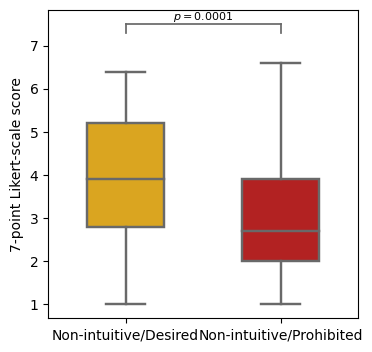

In [116]:
res = testing(nonintuitive_desired2["mean2"].values, nonintuitive_prohibited2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[nonintuitive_desired2["mean2"].values, nonintuitive_prohibited2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Non-intuitive/Desired', 'Non-intuitive/Prohibited'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H3_result5.pdf", bbox_inches='tight')

In [117]:
print(nonintuitive_desired2["mean2"].median())
print(nonintuitive_prohibited2["mean2"].median())

3.9
2.7


### faithful/desired (Condition 1 and 5) <-> faithful/prohibited (Condition 3 and 7)

Sample a:  ShapiroResult(statistic=0.9490795135498047, pvalue=0.013035917654633522)
Sample b:  ShapiroResult(statistic=0.9683803915977478, pvalue=0.12152335047721863)
RanksumsResult(statistic=5.137405182339121, pvalue=1.3927896697394797e-07)


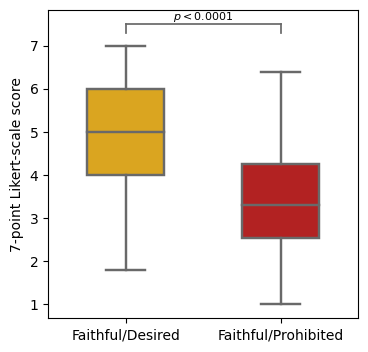

In [118]:
res = testing(desired_faithful2["mean2"].values, prohibited_faithful2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[desired_faithful2["mean2"].values, prohibited_faithful2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Faithful/Desired', 'Faithful/Prohibited'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H3_result1.pdf", bbox_inches='tight')

In [119]:
print(desired_faithful2["mean2"].median())
print(prohibited_faithful2["mean2"].median())

5.0
3.3


### unfaithful/desired (Condition 2 and 6) <-> unfaithful/prohibited (Condition 4 and 8)

Sample a:  ShapiroResult(statistic=0.9692404270172119, pvalue=0.14053481817245483)
Sample b:  ShapiroResult(statistic=0.9684484601020813, pvalue=0.11654140800237656)
Ttest_indResult(statistic=0.8296362974104493, pvalue=0.20420983500207718)


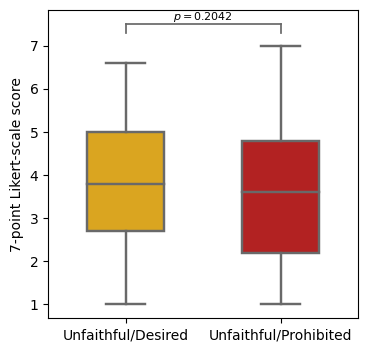

In [120]:
res = testing(desired_unfaithful2["mean2"].values, prohibited_unfaithful2["mean2"].values, 'greater')
print(res)
fig = plot_boxplot_testing(tables=[desired_unfaithful2["mean2"].values, prohibited_unfaithful2["mean2"].values], 
                     colors=['goldenrod', 'firebrick'], xticks=['Unfaithful/Desired', 'Unfaithful/Prohibited'], 
                     yticks=np.arange(1,7+1), ylabel='7-point Likert-scale score', 
                     pval=res.pvalue, figsize=(4, 4))
# fig.savefig(f"./result_imgs/study2/H3_result2.pdf", bbox_inches='tight')

In [121]:
print(len(desired_unfaithful2["mean2"].values), len(prohibited_unfaithful2["mean2"].values))
print(desired_unfaithful2["mean2"].mean())
print(desired_unfaithful2["mean2"].std())
print(prohibited_unfaithful2["mean2"].mean())
print(prohibited_unfaithful2["mean2"].std())

59 61
3.840677966101695
1.3870234371472576
3.6163934426229503
1.565586187116384


### intuitive/faithful/desired (Condition 1) <-> intuitive/unfaithful/desired (Condition 2)

In [122]:
testing(intuitive_faithful_desired1["mean2"].values, intuitive_unfaithful_desired1["mean2"].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)


Ttest_indResult(statistic=2.965656785711339, pvalue=0.004330005629495813)

In [123]:
print(len(intuitive_faithful_desired1["mean2"].values), len(intuitive_unfaithful_desired1["mean2"].values))
print(intuitive_faithful_desired1["mean2"].mean())
print(intuitive_faithful_desired1["mean2"].std())
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())

34 28
5.182352941176471
1.1210034974765797
4.242857142857143
1.3742145423716083


### non-intuitive/faithful/desired (Condition 5) <-> non-intuitive/unfaithful/desired (Condition 6)

In [124]:
testing(nonintuitive_faithful_desired1["mean2"].values, nonintuitive_unfaithful_desired1["mean2"].values, 'two-sided')

Sample a:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)


Ttest_indResult(statistic=2.9016362692321467, pvalue=0.005298252073211345)

In [125]:
print(len(nonintuitive_faithful_desired1["mean2"].values), len(nonintuitive_unfaithful_desired1["mean2"].values))
print(nonintuitive_faithful_desired1["mean2"].mean())
print(nonintuitive_faithful_desired1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

27 31
4.511111111111112
1.3948623679922783
3.4774193548387093
1.316234446548019


## Testing Addition Tests for Appendix

In [126]:
# Condition 1 vs Condition 3
res = testing(intuitive_faithful_desired1["mean2"].values, intuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].mean())
print(intuitive_faithful_desired1["mean2"].std())
print(intuitive_faithful_prohibited1["mean2"].mean())
print(intuitive_faithful_prohibited1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Ttest_indResult(statistic=4.102659684521323, pvalue=0.00012118857553895216)
5.182352941176471
1.1210034974765797
4.026666666666667
1.128604060969471


In [127]:
# Condition 1 vs Condition 4
res = testing(intuitive_faithful_desired1["mean2"].values, intuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].mean())
print(intuitive_faithful_desired1["mean2"].std())
print(intuitive_unfaithful_prohibited1["mean2"].mean())
print(intuitive_unfaithful_prohibited1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Ttest_indResult(statistic=3.299122342380918, pvalue=0.0015762575600410298)
5.182352941176471
1.1210034974765797
4.200000000000001
1.3114877048604


In [128]:
# Condition 1 vs Condition 5
res = testing(intuitive_faithful_desired1["mean2"].values, nonintuitive_faithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].mean())
print(intuitive_faithful_desired1["mean2"].std())
print(nonintuitive_faithful_desired1["mean2"].mean())
print(nonintuitive_faithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Ttest_indResult(statistic=2.084659871899427, pvalue=0.0414375355351489)
5.182352941176471
1.1210034974765797
4.511111111111112
1.3948623679922783


In [129]:
# Condition 1 vs Condition 6
res = testing(intuitive_faithful_desired1["mean2"].values, nonintuitive_unfaithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].mean())
print(intuitive_faithful_desired1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Ttest_indResult(statistic=5.637240649142938, pvalue=4.348282794942674e-07)
5.182352941176471
1.1210034974765797
3.4774193548387093
1.316234446548019


In [130]:
# Condition 1 vs Condition 7
res = testing(intuitive_faithful_desired1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].median())
print(nonintuitive_faithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=5.341021984330721, pvalue=9.242404596046008e-08)
5.0
2.7


In [131]:
# Condition 1 vs Condition 8
res = testing(intuitive_faithful_desired1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_desired1["mean2"].median())
print(nonintuitive_unfaithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9566559195518494, pvalue=0.19393432140350342)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=4.894157855284704, pvalue=9.872757233165567e-07)
5.0
2.5


In [132]:
# Condition 2 vs Condition 3
res = testing(intuitive_unfaithful_desired1["mean2"].values, intuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())
print(intuitive_faithful_prohibited1["mean2"].mean())
print(intuitive_faithful_prohibited1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Ttest_indResult(statistic=0.6565903598315712, pvalue=0.5141335606215987)
4.242857142857143
1.3742145423716083
4.026666666666667
1.128604060969471


In [133]:
# Condition 2 vs Condition 4
res = testing(intuitive_unfaithful_desired1["mean2"].values, intuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())
print(intuitive_unfaithful_prohibited1["mean2"].mean())
print(intuitive_unfaithful_prohibited1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Ttest_indResult(statistic=0.12442533927728681, pvalue=0.9014014691676318)
4.242857142857143
1.3742145423716083
4.200000000000001
1.3114877048604


In [134]:
# Condition 2 vs Condition 5
res = testing(intuitive_unfaithful_desired1["mean2"].values, nonintuitive_faithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())
print(nonintuitive_faithful_desired1["mean2"].mean())
print(nonintuitive_faithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Ttest_indResult(statistic=-0.7184056156317546, pvalue=0.4756624573747871)
4.242857142857143
1.3742145423716083
4.511111111111112
1.3948623679922783


In [135]:
# Condition 2 vs Condition 6
res = testing(intuitive_unfaithful_desired1["mean2"].values, nonintuitive_unfaithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Ttest_indResult(statistic=2.1844448509568215, pvalue=0.03305742905544065)
4.242857142857143
1.3742145423716083
3.4774193548387093
1.316234446548019


In [136]:
# Condition 2 vs Condition 7
res = testing(intuitive_unfaithful_desired1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_desired1["mean2"].mean())
print(intuitive_unfaithful_desired1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=3.2599354559186366, pvalue=0.001114375702378889)
4.242857142857143
1.3742145423716083
3.4774193548387093
1.316234446548019


In [137]:
# Condition 2 vs Condition 8
res = testing(intuitive_unfaithful_desired1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)

Sample a:  ShapiroResult(statistic=0.9451249241828918, pvalue=0.1492001712322235)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=2.9824045403173027, pvalue=0.0028599382084640934)


In [138]:
# Condition 3 vs Condition 5
res = testing(intuitive_faithful_prohibited1["mean2"].values, nonintuitive_faithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_prohibited1["mean2"].mean())
print(intuitive_faithful_prohibited1["mean2"].std())
print(nonintuitive_faithful_desired1["mean2"].mean())
print(nonintuitive_faithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Sample b:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Ttest_indResult(statistic=-1.4476498159794167, pvalue=0.15339148103526754)
4.026666666666667
1.128604060969471
4.511111111111112
1.3948623679922783


In [139]:
# Condition 3 vs Condition 6
res = testing(intuitive_faithful_prohibited1["mean2"].values, nonintuitive_unfaithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_prohibited1["mean2"].mean())
print(intuitive_faithful_prohibited1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Ttest_indResult(statistic=1.7469811221976626, pvalue=0.08584435186310213)
4.026666666666667
1.128604060969471
3.4774193548387093
1.316234446548019


In [140]:
# Condition 3 vs Condition 7
res = testing(intuitive_faithful_prohibited1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_prohibited1["mean2"].median())
print(nonintuitive_faithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=3.385633420971944, pvalue=0.0007101417853454575)
4.0
2.7


In [141]:
# Condition 3 vs Condition 8
res = testing(intuitive_faithful_prohibited1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_faithful_prohibited1["mean2"].median())
print(nonintuitive_unfaithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9702409505844116, pvalue=0.5457892417907715)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=2.8942625050160684, pvalue=0.003800502892441711)
4.0
2.5


In [142]:
# Condition 4 vs Condition 5
res = testing(intuitive_unfaithful_prohibited1["mean2"].values, nonintuitive_faithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_prohibited1["mean2"].mean())
print(intuitive_unfaithful_prohibited1["mean2"].std())
print(nonintuitive_faithful_desired1["mean2"].mean())
print(nonintuitive_faithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Sample b:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Ttest_indResult(statistic=-0.8883946983836245, pvalue=0.3779980842754659)
4.200000000000001
1.3114877048604
4.511111111111112
1.3948623679922783


In [143]:
# Condition 4 vs Condition 6
res = testing(intuitive_unfaithful_prohibited1["mean2"].values, nonintuitive_unfaithful_desired1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_prohibited1["mean2"].mean())
print(intuitive_unfaithful_prohibited1["mean2"].std())
print(nonintuitive_unfaithful_desired1["mean2"].mean())
print(nonintuitive_unfaithful_desired1["mean2"].std())

Sample a:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Sample b:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Ttest_indResult(statistic=2.1989193834922474, pvalue=0.03162328600084847)
4.200000000000001
1.3114877048604
3.4774193548387093
1.316234446548019


In [144]:
# Condition 4 vs Condition 7
res = testing(intuitive_unfaithful_prohibited1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_prohibited1["mean2"].median())
print(nonintuitive_faithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=3.529965071936394, pvalue=0.0004156145314440442)
4.0
2.7


In [145]:
# Condition 4 vs Condition 8
res = testing(intuitive_unfaithful_prohibited1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(intuitive_unfaithful_prohibited1["mean2"].median())
print(nonintuitive_unfaithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9672086834907532, pvalue=0.40721580386161804)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=3.2419537210791223, pvalue=0.001187132983724583)
4.0
2.5


In [146]:
# Condition 5 vs Condition 7
res = testing(nonintuitive_faithful_desired1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(nonintuitive_faithful_desired1["mean2"].median())
print(nonintuitive_faithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=3.691867421437458, pvalue=0.0002226135069691359)
4.8
2.7


In [147]:
# Condition 5 vs Condition 8
res = testing(nonintuitive_faithful_desired1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(nonintuitive_faithful_desired1["mean2"].median())
print(nonintuitive_unfaithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9268630146980286, pvalue=0.05791674181818962)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=3.5102800923189323, pvalue=0.00044763490035906484)
4.8
2.5


In [148]:
# Condition 6 vs Condition 7
res = testing(nonintuitive_unfaithful_desired1["mean2"].values, nonintuitive_faithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(nonintuitive_unfaithful_desired1["mean2"].median())
print(nonintuitive_faithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Sample b:  ShapiroResult(statistic=0.9014521837234497, pvalue=0.009116075001657009)
RanksumsResult(statistic=1.601313196790172, pvalue=0.10930756755059796)
3.4
2.7


In [149]:
# Condition 6 vs Condition 7
res = testing(nonintuitive_unfaithful_desired1["mean2"].values, nonintuitive_unfaithful_prohibited1["mean2"].values, 'two-sided')
print(res)
print(nonintuitive_unfaithful_desired1["mean2"].median())
print(nonintuitive_unfaithful_prohibited1["mean2"].median())

Sample a:  ShapiroResult(statistic=0.9754486083984375, pvalue=0.6783477067947388)
Sample b:  ShapiroResult(statistic=0.9186691045761108, pvalue=0.03215983137488365)
RanksumsResult(statistic=1.639377199941074, pvalue=0.10113472704699439)
3.4
2.5
